# RAILS — Railbed Analysis & Image Learning System

"RAILS“ ist ein fiktiver Projektname und steht in keiner Verbindung zu bestehenden Produkten, Marken oder Organisationen, etwaige Namensähnlichkeiten sind zufällig und nicht beabsichtigt.

Dieses Notebook behandelt die Analyse und das Clustering von Schienenuntergrund-Bilddaten im Rahmen des Master Moduls *„Maschinelles Lernen“*. Grundlage sind rund 50.000 Graustufenbilder aus Messfahrten mehrerer europäischer Städte, die verschiedene Oberbautypen wie Schotter, Asphalt oder Rasen zeigen.  
 
Ziel ist es, mit Hilfe von **Clustering- und Klassifikationsverfahren** Muster und Strukturen in den Daten zu erkennen und die Leistungsfähigkeit unterschiedlicher Ansätze zu vergleichen. Dazu werden die Bilder vorverarbeitet, mithilfe eines vortrainierten CNN in Embeddings überführt und anschließend mit Methoden wie KMeans und DBSCAN gruppiert.
 
Das Notebook ist so strukturiert, dass es den gesamten Workflow von der technischen Vorbereitung bis zur Auswertung abbildet:  
- Zunächst erfolgt das **Setup** der Umgebung sowie die **Konfiguration** der Pfade und Parameter.  
- Anschließend werden **Datensatzstruktur und Metadaten** untersucht, bevor die **Feature-Extraktion** mit einem CNN durchgeführt wird.  
- Die resultierenden Features werden **normalisiert und mittels PCA reduziert**, um sie für Clustering-Algorithmen vorzubereiten.  
- Im Kernteil werden **KMeans** und **DBSCAN** angewendet, systematisch evaluiert und visuell miteinander verglichen.  
- Schließlich werden die **Cluster-Ergebnisse gespeichert**, Reports erzeugt und eine detaillierte **Tenant-Analyse** erstellt.  
 
Im Fokus steht die praktische Anwendung moderner Machine-Learning-Techniken auf reale Daten sowie eine transparente Dokumentation der Ergebnisse mit Metriken und Visualisierungen

# Inhaltsverzeichnis
- [Einleitung](#rails--railbed-analysis--image-learning-system)
- [1. Setup: Importe & Umgebung](#1-setup-importe--umgebung)
- [2. Konfiguration: Pfade, Modellparameter](#2-konfiguration-pfade-modellparameter)
- [3. Ergebnisse-Verzeichnis & Datensatz-Check](#3-ergebnisse-verzeichnis--datensatz-check)
- [4. Dateiname-Parsing, Dataset-Metadaten & Tenant-Verteilung](#4-dateiname-parsing-dataset-metadaten--tenant-verteilung)
- [5. Feature-Extraktion](#5-feature-extraktion)
- [5.1 Feature-Extraktion vorbereiten: Funktionen & Pipeline](#51-feature-extraktion-vorbereiten-funktionen--pipeline)
- [5.2 Feature-Extraktion ausführen (CPU-Only, Timing & Valid-Filter)](#52-feature-extraktion-ausführen-cpu-only-timing--valid-filter)
- [6. Feature-Nachbearbeitung (Normalisierung & PCA → Vorbereitung fürs Clustering)](#6-feature-nachbearbeitung-normalisierung--pca--vorbereitung-fürs-clustering)
- [7. K-Means](#7-k-means)
- [7.1 K-Means: k-Sweep & Clusterbewertung (Inertia, Silhouette, Clustergrößen)](#71-k-means-k-sweep--clusterbewertung-inertia-silhouette-clustergrößen)
- [7.2 K-Means Evaluation visualisieren & k bestimmen](#72-k-means-evaluation-visualisieren--k-bestimmen)
- [7.3 Finales K-Means mit optimalem k & Clusteranalyse](#73-finales-k-means-mit-optimalem-k--clusteranalyse)
- [7.4 K-Means-Clusterbeispiele: Visualisierung von Beispielbildern](#74-k-means-clusterbeispiele-visualisierung-von-beispielbildern)
- [8. DBSCAN](#8-dbscan)
- [8.1 DBSCAN: Parameter-Grid, Heatmaps & Best-Selection](#81-dbscan-parameter-grid-heatmaps--best-selection)
- [9. Visualisierung: K-Means & DBSCAN (Side-by-Side) mit t-SNE](#9-visualisierung-k-means--dbscan-side-by-side-mit-t-sne)
- [9.1 K-Nearest Neighbor Grafik](#91-k-nearest-neighbor-grafik)
- [10. Cluster-Ergebnisse speichern](#10-cluster-ergebnisse-speichern)
- [10.1 Speicher-Helfer definieren (Ordner/Bildkopie/Metadaten)](#101-speicher-helfer-definieren-ordnerbildkopiemetadaten)
- [10.2 K-Means-Cluster speichern (Ausführung)](#102-k-means-cluster-speichern-ausführung)
- [10.3 DBSCAN-Cluster speichern (Ausführung)](#103-dbscan-cluster-speichern-ausführung)
- [11. Tenant-Cluster-Analyse (Heatmap & Detailstatistik)](#11-tenant-cluster-analyse-heatmap--detailstatistik)
- [12. Clustering-Report (JSON) erstellen & Kernergebnisse ausgeben](#12-clustering-report-json-erstellen--kernergebnisse-ausgeben)
- [13. Ergebnisse der Clustering Phase](#13-ergebnisse-der-clustering-phase)

## 1. Setup: Importe & Umgebung

**Was:**  
- Import zentraler Bibliotheken (Datenhandling, Visualisierung, ML/DL).  

**Warum:**  
- Konsistente, reproduzierbare Läufe und Zentralisierung.


In [8]:
# Import Required Libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
import cv2
from collections import Counter, defaultdict
from PIL import Image

# Machine Learning Libraries
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, normalize

# Deep Learning Libraries - Import AFTER setting environment variables
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

# Image Processing
from img_preprocessing import ImagePreprocessor

# Visualization
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Konfiguration: Pfade, Modellparameter

**Was:**  
- Lauf-zeitgestempelte Ergebnisordner anlegen (Analyse + Clusterbilder).  
- Zentrale Hyperparameter für Feature-Extraktion und Clustering definieren.

**Warum:**  
- **`TIMESTAMP`**: Versioniert jeden Run → kein Überschreiben, einfache Nachverfolgung & Vergleichbarkeit.  
- **`DATASET_PATH=...sample_100`**: Kleine Stichprobe zum schnellen Iterieren/Debuggen. Skaliert später auf größere Samples.  
- **`BASE_RESULTS_PATH`/`RESULTS_PATH`/`CLUSTERS_PATH`**: Klare Trennung von Analyseartefakten und exportierten Cluster-Bildern.  
- **`BATCH_SIZE=32`**: Bestimmt wie viele Bilder zeitgleich in den RAM geladen werden.
- **`IMG_SIZE=(224,224)`**: Erwartete Eingabegröße für ResNet50 (ImageNet-Pretraining) → kompatible Modeleingabe.  
- **`FEATURE_DIM=2048`**: Output-Dimensionalität von ResNet50 → korrektes Erwartungs-Shape für Downstream-Schritte.  
- **`N_CLUSTERS_RANGE=range(3,16)`**: Typischer, kompakter k-Bereich für K-Means-Sweep (Balance aus Rechenzeit und Abdeckung kleiner/mittlerer k).  
- **`PCA_COMPONENTS=50`**: Anzahl der Principal Componentes. Angewandt zur Dimensionsreduktion.
- **`RANDOM_STATE=42`**: Reproduzierbarkeit über PCA/t-SNE/K-Means hinweg.

**Besonderheiten:**  
- `TIMESTAMP` prägt alle Output-Pfade (kein Überschreiben alter Ergebnisse).  
- `N_CLUSTERS_RANGE=3..15` für den k-Sweep (K-Means/MiniBatchKMeans).

**Outputs:**  
- Konsolenhinweis mit Zielpfaden (`RESULTS_PATH`, `CLUSTERS_PATH`).  
- Keine Dateien an dieser Stelle – nur Konfiguration.


In [9]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f"Analysis timestamp: {TIMESTAMP}")
DATASET_PATH = "./datasets/clustering_sample_10000_v1"
BASE_RESULTS_PATH = f"./results_{TIMESTAMP}"
RESULTS_PATH = f"{BASE_RESULTS_PATH}/clustering_analysis"
CLUSTERS_PATH = f"{BASE_RESULTS_PATH}/clustered_images"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
FEATURE_DIM = 2048
N_CLUSTERS_RANGE = range(3, 16)
PCA_COMPONENTS = 50
RANDOM_STATE = 42

print(f"Results will be saved to:")
print(f"  Analysis results: {RESULTS_PATH}")
print(f"  Clustered images: {CLUSTERS_PATH}")


Analysis timestamp: 20250907_143420
Results will be saved to:
  Analysis results: ./results_20250907_143420/clustering_analysis
  Clustered images: ./results_20250907_143420/clustered_images


## 3. Ergebnisse-Verzeichnis & Datensatz-Check

**Was:**  
- Anlage laufzeitgestempelter Ergebnisordner (Analyse, Clusterbilder), Ausgabe der Pfade.  
- Sanity-Check des Datensatzpfads; Fallback: Auflistung vorhandener Datasets mit Bildanzahl.
- Zählen aller `.png`-Dateien im gewählten Dataset.  
- Persistieren einer `run_metadata.json` (Pfad- und Konfig-Snapshot).

**Warum:**  
- **Ordnererstellung** verhindert Fehler bei wiederholten Läufen.  
- **Pfad-/Existenz-Check** reduziert Fehlersuche bei falschen Datasetangaben.  
- **Bildzählung** schafft Transparenz (Basis für spätere Prozentangaben, Laufzeitabschätzungen).  
- **`run_metadata.json`** dokumentiert Pfade & Konfiguration (Reproduzierbarkeit, Vergleichbarkeit zwischen Runs).

**Outputs:**  
- Verzeichnisse: `RESULTS_PATH`, `CLUSTERS_PATH`  
- Datei: `RESULTS_PATH/run_metadata.json`  
- Konsolen-Logs mit Pfaden und Bildanzahl


In [10]:
# Create timestamped result roots (idempotent: no error if folders already exist)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
Path(CLUSTERS_PATH).mkdir(parents=True, exist_ok=True)

print(f"Created timestamped directories:")
print(f"Dataset path: {DATASET_PATH}")
print(f"Analysis results path: {RESULTS_PATH}")
print(f"Clustered images path: {CLUSTERS_PATH}")

# Check dataset existence; if missing, enumerate available subfolders under ./datasets
if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset path {DATASET_PATH} does not exist!")
    print("Available dataset directories:")
    datasets_dir = Path("./datasets")
    if datasets_dir.exists():
        for subdir in datasets_dir.iterdir():
            if subdir.is_dir():
                # Count only files ending with '.png' (case-sensitive)
                img_count = len([f for f in subdir.iterdir() if f.suffix == '.png'])
                print(f"  {subdir.name}: {img_count} images")
else:
    # Count .png files in the selected dataset (flat folder expected)
    img_count = len([f for f in Path(DATASET_PATH).iterdir() if f.suffix == '.png'])
    print(f"Found {img_count} images in dataset")

# Build a metadata snapshot for this run (paths, counts, and core configuration)
run_metadata = {
    'timestamp': TIMESTAMP,  # run identifier
    'dataset_path': str(Path(DATASET_PATH).resolve()),
    'total_images_found': img_count if os.path.exists(DATASET_PATH) else 0,
    'analysis_results_path': str(Path(RESULTS_PATH).resolve()),
    'clustered_images_path': str(Path(CLUSTERS_PATH).resolve()),
    'configuration': {
        'batch_size': BATCH_SIZE,
        'img_size': IMG_SIZE,
        'feature_dim': FEATURE_DIM,
        'n_clusters_range': list(N_CLUSTERS_RANGE),
        'pca_components': PCA_COMPONENTS,
        'random_state': RANDOM_STATE
    }
}

# Persist metadata to JSON for reproducibility/audit
with open(f"{RESULTS_PATH}/run_metadata.json", 'w') as f:
    json.dump(run_metadata, f, indent=2)
    
print(f"\nRun metadata saved to: {RESULTS_PATH}/run_metadata.json")


Created timestamped directories:
Dataset path: ./datasets/clustering_sample_10000_v1
Analysis results path: ./results_20250907_143420/clustering_analysis
Clustered images path: ./results_20250907_143420/clustered_images
Found 10000 images in dataset

Run metadata saved to: ./results_20250907_143420/clustering_analysis/run_metadata.json


## 4. Dateiname-Parsing, Dataset-Metadaten & Tenant-Verteilung

**Was:**  
- Parsen der Dateinamen mit Suffix `_C.png`, um **tenant**, **SID** und **original_filename** zu extrahieren.  
- Einlesen des Datasets zu einer **Dateiliste** und Aggregation der **Tenant-Verteilung**.
- Ausgabe von **Gesamtzahl**, **#Tenants** und **Prozentanteilen** je Tenant.

**Warum:**  
- Die Metadaten aus dem Dateinamen erlauben **Slicing** (z. B. Auswertung pro Tenant) und **Qualitätskontrollen** (Ungleichgewichte erkennen).  
- Die Fokussierung auf `_C.png` stellt sicher, dass nur **konforme, bereinigte** Bildvarianten verarbeitet werden (einheitliche Pipeline).

**Outputs:**  
- `image_files` (Liste mit Pfad + extrahierten Metadaten)  
- `tenant_distribution` (Dict mit Zählungen)  
- Konsolen-Logs (Totals, #Tenants, Verteilung in %)


In [11]:
def parse_filename(filename: str):
    """Parse filename to extract tenant, SID, and original filename."""
    # Expect filenames ending with '_C.png' (case-sensitive)
    # Pattern convention: {tenant}_{sid}_{original}_C.png
    if not filename.endswith('_C.png'):
        return None, None, None
    
    name_without_ext = filename[:-6]  # Remove '_C.png' (6 characters)
    parts = name_without_ext.split('_')
    
    # Require at least 3 parts: tenant, sid, and the remaining original name
    if len(parts) >= 3:
        tenant = parts[0]
        sid = parts[1]
        original_filename = '_'.join(parts[2:])
        return tenant, sid, original_filename
    
    # Fallback if naming does not match the expected convention
    return None, None, None

def load_dataset_info(dataset_path: str):
    """Load and analyze dataset information."""
    # Build file index and aggregate tenant counts based on parsed filenames
    image_files = []
    tenant_distribution = defaultdict(int)
    
    # Non-recursive, case-sensitive pattern: only matches '*_C.png' in the given folder
    for file_path in Path(dataset_path).glob('*_C.png'):
        filename = file_path.name
        tenant, sid, original_name = parse_filename(filename)
        
        # Keep only files that match the naming convention
        if tenant:
            image_files.append({
                'filepath': str(file_path),
                'filename': filename,
                'tenant': tenant,
                'sid': sid,
                'original_name': original_name
            })
            tenant_distribution[tenant] += 1
    
    return image_files, dict(tenant_distribution)

# Load dataset information (flat folder expected)
print("Loading dataset information...")
image_files, tenant_distribution = load_dataset_info(DATASET_PATH)

# Summary (assumes >=1 valid image; add guard if needed)
print(f"\nTotal images: {len(image_files)}")
print(f"Number of tenants: {len(tenant_distribution)}")
print("\nTenant distribution:")
for tenant, count in sorted(tenant_distribution.items()):
    percentage = (count / len(image_files)) * 100
    print(f"  {tenant}: {count} images ({percentage:.1f}%)")


Loading dataset information...

Total images: 10000
Number of tenants: 8

Tenant distribution:
  ava: 1250 images (12.5%)
  bernmobil: 1250 images (12.5%)
  bvb: 1250 images (12.5%)
  cts: 1250 images (12.5%)
  gent: 1250 images (12.5%)
  gvb: 1250 images (12.5%)
  retm: 1250 images (12.5%)
  vbz: 1250 images (12.5%)


### 5. Feature-Extraktion

### 5.1 Feature-Extraktion vorbereiten: Funktionen & Pipeline

**Was:**  
- Hilfsfunktionen zum Laden und ggf. Vorverarbeiten einzelner Bilder, Erzeugen des ResNet50-Encoders und batchweises Ableiten der Feature-Embeddings (2048-D).

**Warum:**  
- Saubere Trennung von I/O, Modellkonstruktion und Batch-Verarbeitung erleichtert Debugging und spätere Modellaustausche (z. B. anderer Encoder).

**Besonderheiten:**  
- 5 mögliche Vorverarbeitungsfunktionen (img_processing.py)

**Outputs:**  
- Keinerlei Dateien. Rückgaben sind In-Memory: Feature-Matrizen (N×2048) und gültige Pfade.


In [12]:
def load_and_preprocess_image(image_path: str, target_size: tuple = IMG_SIZE):
    """Load and preprocess image for ResNet50."""
    try:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        # insert preprocessing here
        # for exmaple:
        #img = ImagePreprocessor.method_3_gamma_correction(img)
        img_array = image.img_to_array(img)    
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

def create_feature_extractor():
    """Create ResNet50 feature extractor (without top classification layer)."""
    print("Loading ResNet50 model...")
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        pooling='avg'  # Global average pooling
    )
    
    # The model output will be (batch_size, 2048) features
    print(f"Feature extractor output shape: {base_model.output_shape}")
    return base_model

def extract_features_batch(model, image_paths: list, batch_size: int = BATCH_SIZE):
    """Extract features from images in batches."""
    features = []
    valid_paths = []
    
    print(f"Extracting features from {len(image_paths)} images...")
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        batch_valid_paths = []
        
        # Load batch images
        for img_path in batch_paths:
            img_array = load_and_preprocess_image(img_path)
            if img_array is not None:
                batch_images.append(img_array[0])  # Remove batch dimension
                batch_valid_paths.append(img_path)
        
        if batch_images:
            # Convert to numpy array and predict
            batch_images = np.array(batch_images)
            batch_features = model.predict(batch_images, verbose=0)
            
            features.extend(batch_features)
            valid_paths.extend(batch_valid_paths)
        
        # Progress update
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {min(i + batch_size, len(image_paths))}/{len(image_paths)} images")
    
    return np.array(features), valid_paths

### 5.2 Feature-Extraktion ausführen (CPU-Only, Timing & Valid-Filter)

**Was:**  
- Initialisieren des ResNet50-Feature-Extractors, Sammeln der `image_paths` und batchweise Extraktion der Embeddings.  
- Messen der Laufzeit und Ausgeben von Kernwerten (Shape, Anzahl gültiger Bilder).  
- Filtern nicht ladbarer Bilder und Aktualisieren von `image_files` auf die valide Teilmenge.

**Warum:**  
- Laufzeitmessung hilft bei der Abschätzung von Skalierung und Batchgrößen.  
- Der Valid-Filter stellt sicher, dass nachfolgende Schritte (Clustering) nur konsistente Daten verarbeiten.

**Besonderheiten:**  
- Erwartete Feature-Form: `(N, 2048)` (ResNet50 + GlobalAvgPooling).  
- Die Reihenfolge der `valid_paths` bleibt mit `image_files` konsistent (wichtig für spätere Zuordnungen).

**Outputs:**  
- In-Memory: `features` (N×2048), `valid_paths`, bereinigtes `image_files`.  
- Konsole: Laufzeit, Shape, Zählstatistik.


In [13]:
# Extract features using ResNet50
print("=" * 80)
print("FEATURE EXTRACTION")
print("=" * 80)

# Create feature extractor
feature_extractor = create_feature_extractor()  # builds ResNet50 backbone 

# Extract image paths
image_paths = [item['filepath'] for item in image_files]  # preserve order for alignment with features

# Extract features
start_time = time.time()
features, valid_paths = extract_features_batch(feature_extractor, image_paths)  # batched inference
extraction_time = time.time() - start_time

print(f"\nFeature extraction completed in {extraction_time:.2f} seconds")
print(f"Extracted features shape: {features.shape}")  # expect (N_valid, 2048)
print(f"Valid images: {len(valid_paths)}/{len(image_paths)}")

# Update image_files to only include valid images
valid_image_files = []
for img_file in image_files:
    if img_file['filepath'] in valid_paths:  # keep only successfully processed paths
        valid_image_files.append(img_file)

image_files = valid_image_files  # downstream steps use the filtered metadata list
print(f"Updated image files: {len(image_files)}")


FEATURE EXTRACTION
Loading ResNet50 model...
Feature extractor output shape: (None, 2048)
Extracting features from 10000 images...


I0000 00:00:1757248463.380198  102418 service.cc:146] XLA service 0x7f77b0148d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757248463.380220  102418 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-09-07 14:34:23.460168: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-07 14:34:23.909460: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1757248466.542342  102418 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Processed 320/10000 images
  Processed 640/10000 images
  Processed 960/10000 images
  Processed 1280/10000 images
  Processed 1600/10000 images
  Processed 1920/10000 images
  Processed 2240/10000 images
  Processed 2560/10000 images
  Processed 2880/10000 images
  Processed 3200/10000 images
  Processed 3520/10000 images
  Processed 3840/10000 images
  Processed 4160/10000 images
  Processed 4480/10000 images
  Processed 4800/10000 images
  Processed 5120/10000 images
  Processed 5440/10000 images
  Processed 5760/10000 images
  Processed 6080/10000 images
  Processed 6400/10000 images
  Processed 6720/10000 images
  Processed 7040/10000 images
  Processed 7360/10000 images
  Processed 7680/10000 images
  Processed 8000/10000 images
  Processed 8320/10000 images
  Processed 8640/10000 images
  Processed 8960/10000 images
  Processed 9280/10000 images
  Processed 9600/10000 images
  Processed 9920/10000 images

Feature extraction completed in 60.02 seconds
Extracted features shape: 

## 6. Feature-Nachbearbeitung (Normalisierung & PCA → Vorbereitung fürs Clustering)

**Was:**  
- L2-Normierung der Embeddings (zeilenweise) und optionale PCA-Reduktion auf `PCA_COMPONENTS`.  
- Ausgeben von Kennzahlen vor/nach Normalisierung sowie erklärter Gesamtvarianz der PCA.

**Warum:**  
- L2-Normierung macht Distanzen vergleichbar (≈ spherical K-Means) und stabilisiert Metriken.  
- PCA reduziert Dimensionen, Rauschen und Rechenzeit. kann die Trennbarkeit für K-Means/DBSCAN verbessern.

**Besonderheiten:**  
- PCA-Fit erfolgt auf **normalisierten** Features; `random_state` für Reproduzierbarkeit gesetzt.  
- Default für das Clustering sind die **voll normalisierten** Features. PCA-Features optional testen/umschalten.

**Outputs:**  
- `features_normalized`, `features_pca`
- Konsolen-Stats (vor/nach Normalisierung, PCA-Varianz, Shapes)


In [14]:
# Normalize features to unit length per sample (stabilizes distances for K-Means/DBSCAN)
print("Normalizing features...")
features_normalized = normalize(features, norm='l2', axis=1)

# Basic sanity statistics before/after normalization
print(f"Original feature statistics:")
print(f"  Mean: {features.mean():.4f}")
print(f"  Std: {features.std():.4f}")
print(f"  Min: {features.min():.4f}")
print(f"  Max: {features.max():.4f}")

print(f"\nNormalized feature statistics:")
print(f"  Mean: {features_normalized.mean():.4f}")
print(f"  Std: {features_normalized.std():.4f}")
print(f"  L2 norm (first sample): {np.linalg.norm(features_normalized[0]):.4f}")

# Optional dimensionality reduction (denoising + speed-up for clustering/TSNE)
print(f"\nApplying PCA to reduce dimensions from {FEATURE_DIM} to {PCA_COMPONENTS}...")
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
features_pca = pca.fit_transform(features_normalized)

# Report explained variance (sum) and resulting shape
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
print(f"PCA features shape: {features_pca.shape}")


Normalizing features...
Original feature statistics:
  Mean: 0.2479
  Std: 0.8876
  Min: 0.0000
  Max: 22.0882

Normalized feature statistics:
  Mean: 0.0059
  Std: 0.0213
  L2 norm (first sample): 1.0000

Applying PCA to reduce dimensions from 2048 to 50...
PCA explained variance ratio: 0.9154
PCA features shape: (10000, 50)


## 7. K-Means

### 7.1 K-Means: k-Sweep & Clusterbewertung (Inertia, Silhouette, Clustergrößen)

**Was:**  
- k-Sweep: systematisches Durchtesten mehrerer Clusterzahlen `k` (z. B. 3–15), um anhand von Metriken (Silhouette/Inertia) das sinnvollste `k` zu wählen
- Systematischer k-Sweep über `N_CLUSTERS_RANGE` auf `features_pca` (standardmäßig **MiniBatchKMeans**).  
- Für jedes k: Fit & Predict → **Inertia**, **Silhouette-Score** und **Clustergrößen** (min/max, Verteilung); Modell wird mitgespeichert.

**Warum:**  
- Der k-Sweep liefert eine **datengetriebene Wahl** der Clusterzahl 
  **Silhouette** bewertet Trennung/Kompaktheit (höher = besser), **Inertia** zeigt den „Elbow“ (abnehmender Grenznutzen).  
- **MiniBatchKMeans** skaliert besser auf größere N, ist für Embeddings meist ausreichend präzise.

**Besonderheiten:**  
- `n_init=10` reduziert die Chance auf schlechte lokale Minima. 

**Outputs:**  
- `kmeans_results`: Liste von Dicts `{k, inertia, silhouette_score, min_cluster_size, max_cluster_size, cluster_sizes, model}`
- Konsolen-Logs pro k (Inertia, Silhouette)

In [15]:
def evaluate_kmeans_clusters(features, k_range, use_minibatch=True):
    # Assumes features are L2-normalized for stable distance geometry (spherical k-means behavior).
    # Computes inertia, silhouette, and size diagnostics per k. stores the fitted model for later reuse.
    """Evaluate K-Means clustering for different k values."""
    results = []
    
    print(f"Evaluating K-Means for k in {list(k_range)}...")
    
    for k in k_range:
        print(f"  Testing k={k}...")
        
        # Use MiniBatchKMeans for efficiency with large datasets
        if use_minibatch:
            kmeans = MiniBatchKMeans(
                n_clusters=k,
                random_state=RANDOM_STATE,
                batch_size=100,
                n_init=10
            )
        else:
            kmeans = KMeans(
                n_clusters=k,
                random_state=RANDOM_STATE,
                n_init=10
            )
        
        # Fit and predict
        cluster_labels = kmeans.fit_predict(features)
        
        # Calculate metrics
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(features, cluster_labels)
        
        # Cluster sizes
        cluster_sizes = Counter(cluster_labels)
        min_cluster_size = min(cluster_sizes.values())
        max_cluster_size = max(cluster_sizes.values())
        
        results.append({
            'k': k,
            'inertia': inertia,
            'silhouette_score': silhouette_avg,
            'min_cluster_size': min_cluster_size,
            'max_cluster_size': max_cluster_size,
            'cluster_sizes': dict(cluster_sizes),
            'model': kmeans
        })
        
        print(f"    Inertia: {inertia:.2f}, Silhouette: {silhouette_avg:.4f}")
    
    return results

# Evaluate K-Means clustering
print("=" * 80)
print("K-MEANS CLUSTERING EVALUATION")
print("=" * 80)

# Runs the k-sweep and collects metrics/models per k
kmeans_results = evaluate_kmeans_clusters(features_pca, N_CLUSTERS_RANGE)


K-MEANS CLUSTERING EVALUATION
Evaluating K-Means for k in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]...
  Testing k=3...
    Inertia: 1568.23, Silhouette: 0.3852
  Testing k=4...
    Inertia: 1353.45, Silhouette: 0.3997
  Testing k=5...
    Inertia: 1276.90, Silhouette: 0.3439
  Testing k=6...
    Inertia: 1068.08, Silhouette: 0.4285
  Testing k=7...
    Inertia: 1046.21, Silhouette: 0.3492
  Testing k=8...
    Inertia: 953.05, Silhouette: 0.3791
  Testing k=9...
    Inertia: 909.24, Silhouette: 0.3696
  Testing k=10...
    Inertia: 855.68, Silhouette: 0.3423
  Testing k=11...
    Inertia: 848.12, Silhouette: 0.3061
  Testing k=12...
    Inertia: 807.52, Silhouette: 0.3383
  Testing k=13...
    Inertia: 793.73, Silhouette: 0.3650
  Testing k=14...
    Inertia: 785.57, Silhouette: 0.3083
  Testing k=15...
    Inertia: 763.51, Silhouette: 0.3358


### 7.2 K-Means Evaluation visualisieren & k bestimmen

**Was:**  
- 2×2-Dashboard: Elbow (Inertia), Silhouette, Clustergrößen (min/max), kombinierte Metriken.  
- Bestimmung von `optimal_k` über das Maximum des Silhouette-Scores.

**Warum:**  
- **Inertia** zeigt den „Knick“ (abnehmender Grenznutzen), **Silhouette** misst Trennung & Kompaktheit.  
- **Kombination** (1−normierte Inertia & normierte Silhouette) hilft, widersprüchliche Signale zu balancieren.

**Besonderheiten:**  
- `1 - norm_inertias` sorgt für gleiche Zielfunktion („höher ist besser“).  
- Stabilität prüfen: keine Mini-Cluster, Domänensinn; Elbow nur als Plausibilisierung.

**Outputs:**  
- Plot `kmeans_evaluation.png`, `optimal_k`, bester Silhouette-Wert.


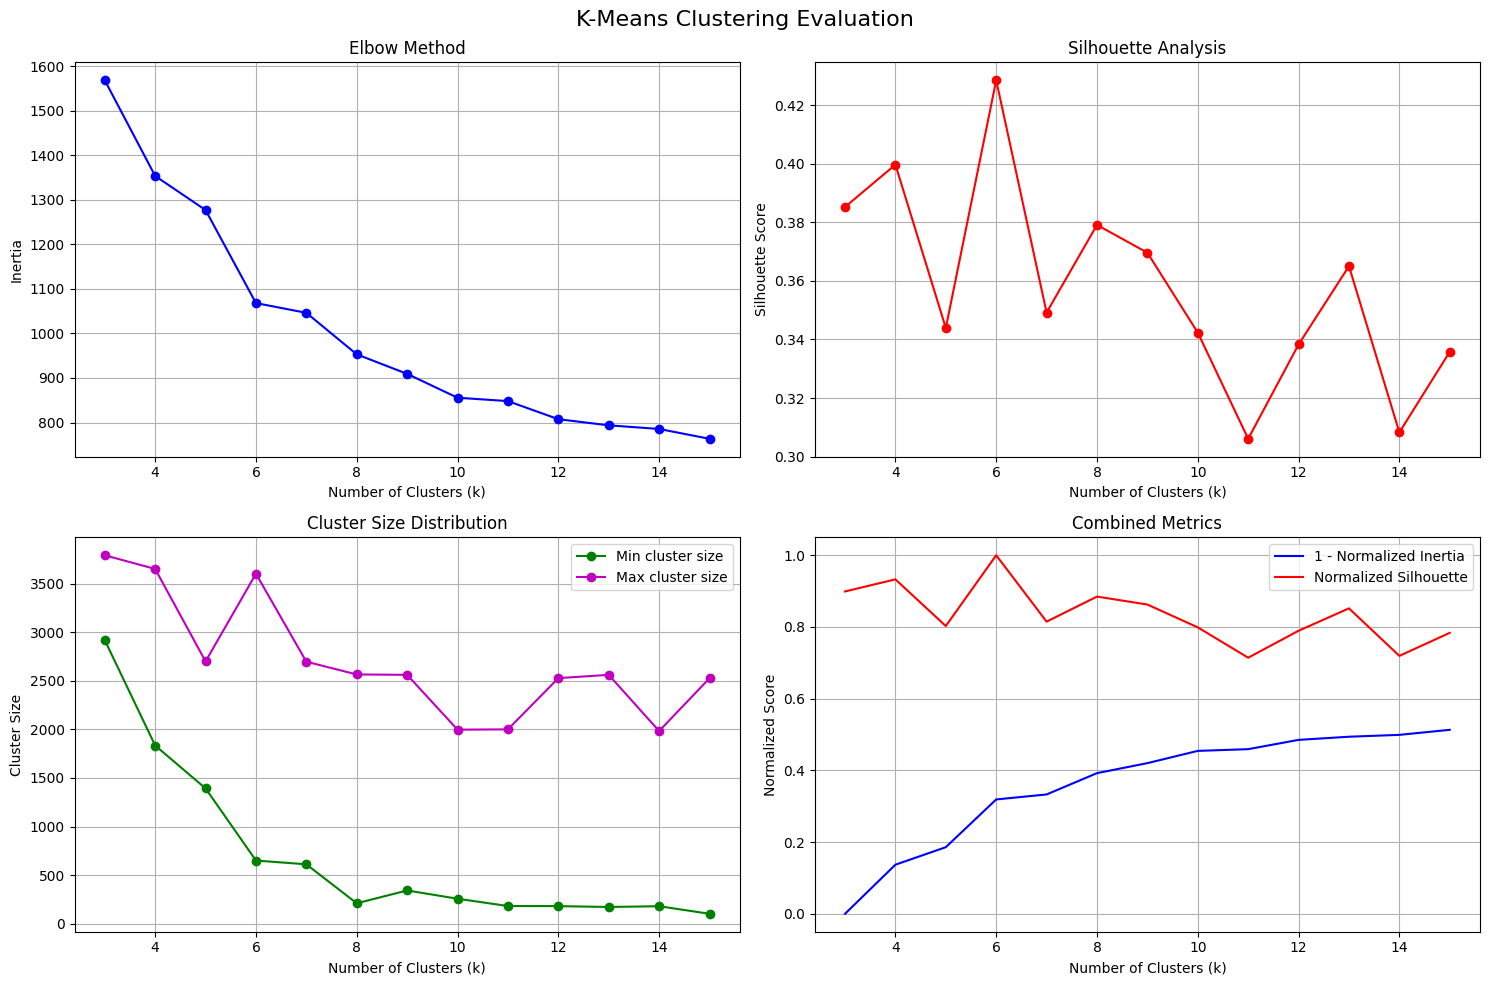


Optimal k based on silhouette score: 6
Best silhouette score: 0.4285


In [16]:
# --- Visualization of k-sweep metrics & selection of k* ---

# Plot K-Means evaluation results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('K-Means Clustering Evaluation', fontsize=16)

# Extract data for plotting (one value per tested k)
k_values = [r['k'] for r in kmeans_results]
inertias = [r['inertia'] for r in kmeans_results]
silhouette_scores = [r['silhouette_score'] for r in kmeans_results]
min_cluster_sizes = [r['min_cluster_size'] for r in kmeans_results]
max_cluster_sizes = [r['max_cluster_size'] for r in kmeans_results]

# --- Elbow plot (Inertia vs k): look for the knee / diminishing returns ---
axes[0, 0].plot(k_values, inertias, 'bo-')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True)

# --- Silhouette score vs k: pick the maximum as primary criterion ---
axes[0, 1].plot(k_values, silhouette_scores, 'ro-')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Analysis')
axes[0, 1].grid(True)

# --- Cluster size diagnostics: min/max sizes vs k (imbalances, tiny clusters) ---
axes[1, 0].plot(k_values, min_cluster_sizes, 'go-', label='Min cluster size')
axes[1, 0].plot(k_values, max_cluster_sizes, 'mo-', label='Max cluster size')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Cluster Size')
axes[1, 0].set_title('Cluster Size Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True)

# --- Combined metrics (normalized): align direction to "higher is better" ---
norm_inertias = np.array(inertias) / max(inertias)            # scale to [0,1]
norm_silhouettes = np.array(silhouette_scores) / max(silhouette_scores)  # scale to [0,1]
axes[1, 1].plot(k_values, 1 - norm_inertias, 'b-', label='1 - Normalized Inertia')
axes[1, 1].plot(k_values, norm_silhouettes, 'r-', label='Normalized Silhouette')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Normalized Score')
axes[1, 1].set_title('Combined Metrics')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/kmeans_evaluation.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Select optimal k by maximum silhouette (primary criterion) ---
best_silhouette_idx = np.argmax(silhouette_scores)
optimal_k = k_values[best_silhouette_idx]
print(f"\nOptimal k based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {silhouette_scores[best_silhouette_idx]:.4f}")


### 7.3 Finales K-Means mit optimalem k & Clusteranalyse

**Was:**  
- Finales Fitting von `MiniBatchKMeans` mit `k=optimal_k`. 
- Anreicherung von `image_files` um das Feld `cluster`.  
- Aggregation einer Clusterübersicht inkl. **Tenant-Verteilung** je Cluster.

**Warum:**  
- Nach dem k-Sweep wird das beste k produktiv angewendet. Die resultierenden Labels bilden die Basis für Analyse, Export und Visualisierung.  
- Tenant-Verteilungen helfen, **Bias/Imbalance** zu erkennen und Cluster zu interpretieren.

**Besonderheiten:**  
- `n_init=20` senkt das Risiko schlechter lokaler Minima im finalen Fit.  
- Die Reihenfolge von `image_files` muss den `cluster_labels` entsprechen (hier gegeben).  
- Prozentanteile werden je Cluster relativ zu dessen Größe berechnet.

**Outputs:**  
- In-Memory: `cluster_labels`, angereichertes `image_files` (mit `cluster`).  
- Konsole: Größe je Cluster und Tenant-Rangfolge pro Cluster.


In [17]:
# Runs MiniBatchKMeans once more with stronger n_init and assigns labels to all samples
print(f"\nPerforming final K-Means clustering with k={optimal_k}...")

final_kmeans = MiniBatchKMeans(
    n_clusters=optimal_k,
    random_state=RANDOM_STATE,
    batch_size=100,
    n_init=20  # More initializations for final model
)

cluster_labels = final_kmeans.fit_predict(features_pca)

# Enrich metadata: attach the integer cluster label to each image_file entry
for i, img_file in enumerate(image_files):
    img_file['cluster'] = int(cluster_labels[i])

# Cluster composition analysis (counts per cluster and tenant distribution)
print(f"\nCluster Analysis:")
cluster_stats = defaultdict(lambda: defaultdict(int))

for img_file in image_files:
    cluster = img_file['cluster']
    tenant = img_file['tenant']
    cluster_stats[cluster]['total'] += 1
    cluster_stats[cluster][tenant] += 1

# Human-readable report per cluster (size + tenant ranking)
for cluster_id in sorted(cluster_stats.keys()):
    stats = cluster_stats[cluster_id]
    total = stats['total']
    print(f"\nCluster {cluster_id}: {total} images")
    
    # Show tenant distribution in this cluster
    tenant_counts = {k: v for k, v in stats.items() if k != 'total'}
    for tenant, count in sorted(tenant_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total) * 100
        print(f"  {tenant}: {count} ({percentage:.1f}%)")



Performing final K-Means clustering with k=6...

Cluster Analysis:

Cluster 0: 944 images
  cts: 528 (55.9%)
  gent: 250 (26.5%)
  bernmobil: 78 (8.3%)
  gvb: 56 (5.9%)
  vbz: 22 (2.3%)
  retm: 10 (1.1%)

Cluster 1: 3571 images
  bernmobil: 1105 (30.9%)
  gvb: 857 (24.0%)
  gent: 724 (20.3%)
  vbz: 561 (15.7%)
  cts: 241 (6.7%)
  retm: 43 (1.2%)
  bvb: 20 (0.6%)
  ava: 20 (0.6%)

Cluster 2: 2562 images
  bvb: 1226 (47.9%)
  vbz: 627 (24.5%)
  ava: 578 (22.6%)
  gvb: 122 (4.8%)
  retm: 9 (0.4%)

Cluster 3: 1345 images
  ava: 650 (48.3%)
  retm: 606 (45.1%)
  gvb: 28 (2.1%)
  bernmobil: 27 (2.0%)
  gent: 21 (1.6%)
  cts: 8 (0.6%)
  vbz: 5 (0.4%)

Cluster 4: 650 images
  retm: 548 (84.3%)
  gvb: 65 (10.0%)
  vbz: 23 (3.5%)
  cts: 9 (1.4%)
  bvb: 3 (0.5%)
  gent: 1 (0.2%)
  ava: 1 (0.2%)

Cluster 5: 928 images
  cts: 464 (50.0%)
  gent: 254 (27.4%)
  gvb: 122 (13.1%)
  bernmobil: 40 (4.3%)
  retm: 34 (3.7%)
  vbz: 12 (1.3%)
  bvb: 1 (0.1%)
  ava: 1 (0.1%)


### 7.4 K-Means-Clusterbeispiele: Visualisierung von Beispielbildern

**Was:**  
- Zeigt pro Cluster eine Stichprobe zufälliger Bilder in einem Bildgrid (3 Spalten, mehrere Zeilen).  
- Nutzt die finalen K-Means-Labels (`image_files[i]['cluster']`) als Grundlage.

**Warum:**  
- Schnelle, visuelle Qualitätsprüfung der Clusterinhalte (Plausibilität, Ausreißer, Muster).

**Besonderheiten:**  
- Zufallsstichprobe ≠ „repräsentativste“ Beispiele. 
- Fehlerhafte oder fehlende Dateien werden textuell im Grid gekennzeichnet.  
- Ergebnisse werden als `cluster_<id>_examples.png` gespeichert.

**Outputs:**
- PNG-Bildtafeln je Cluster unter `RESULTS_PATH`, Konsolenlogs.


CLUSTER EXAMPLES


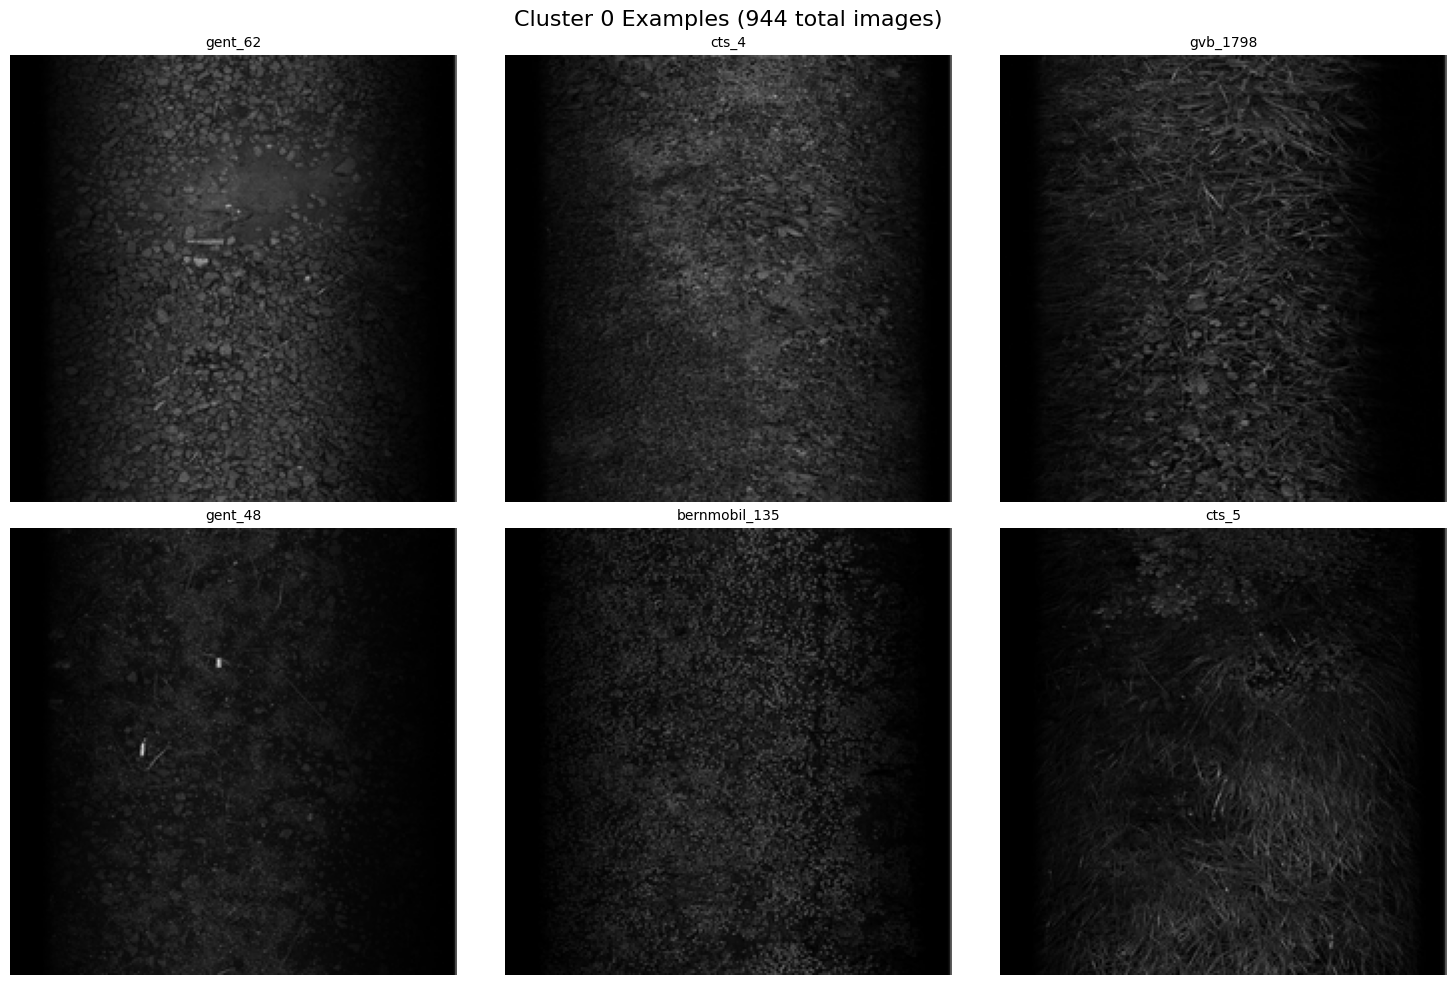

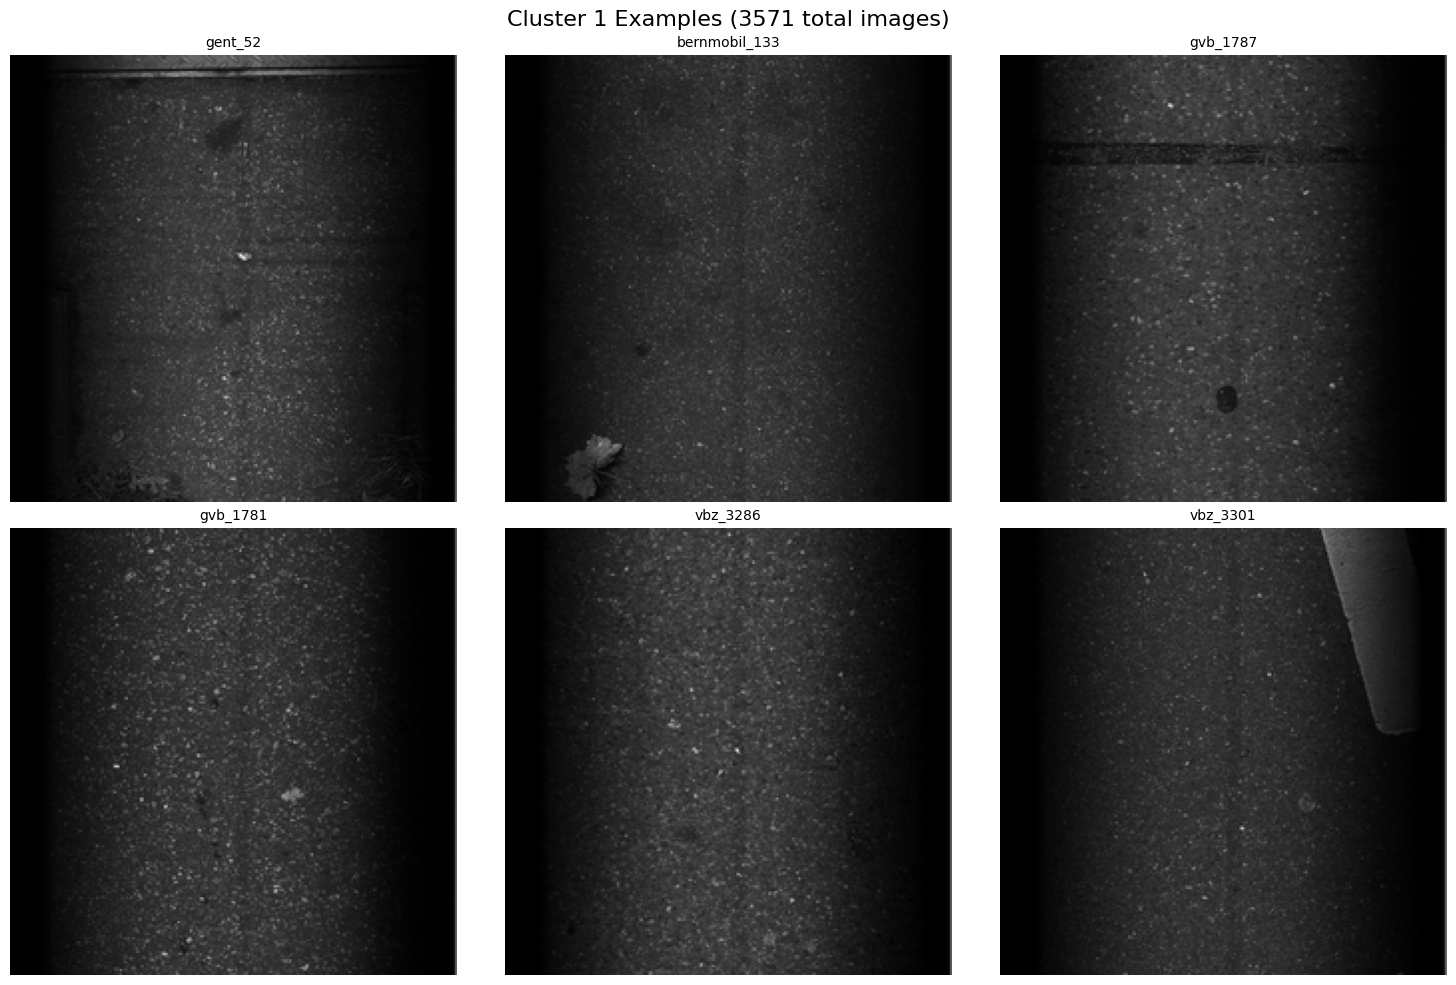

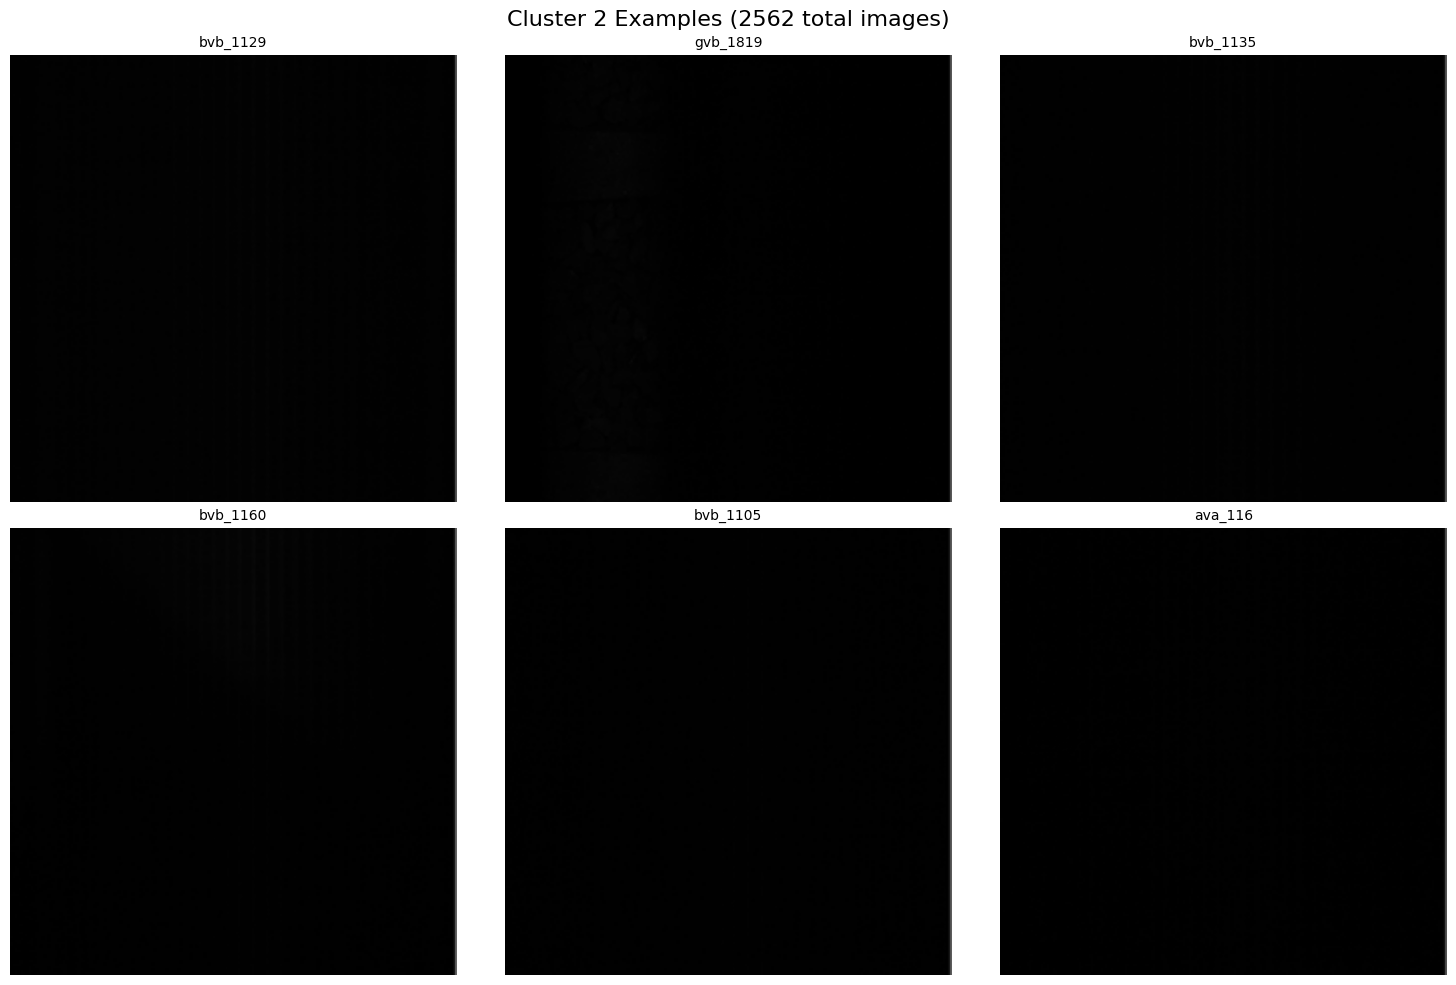

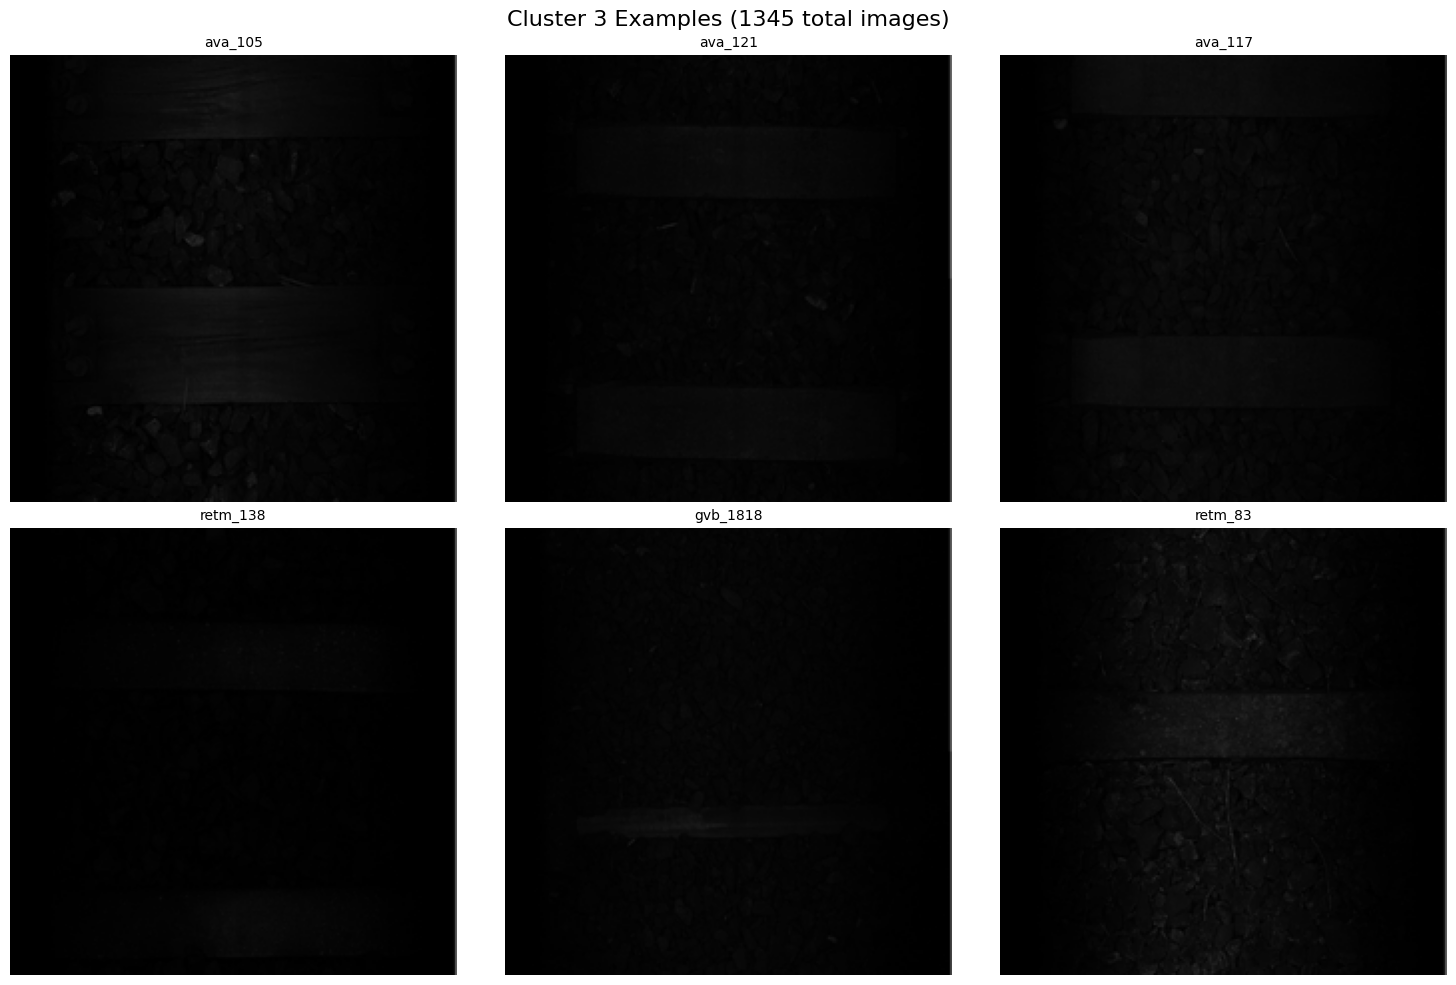

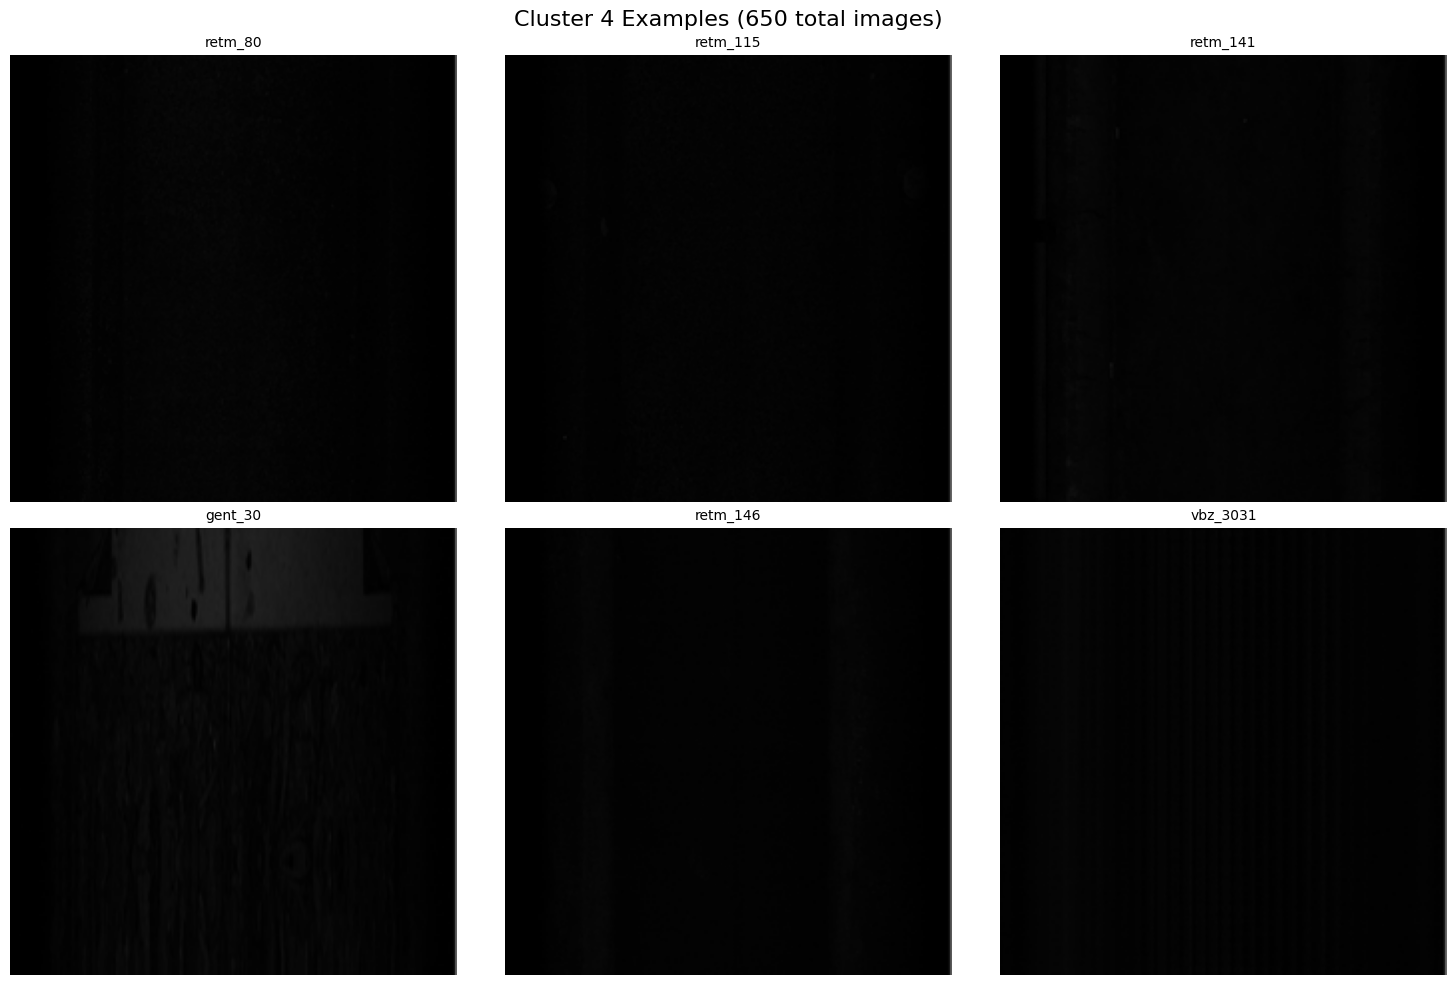

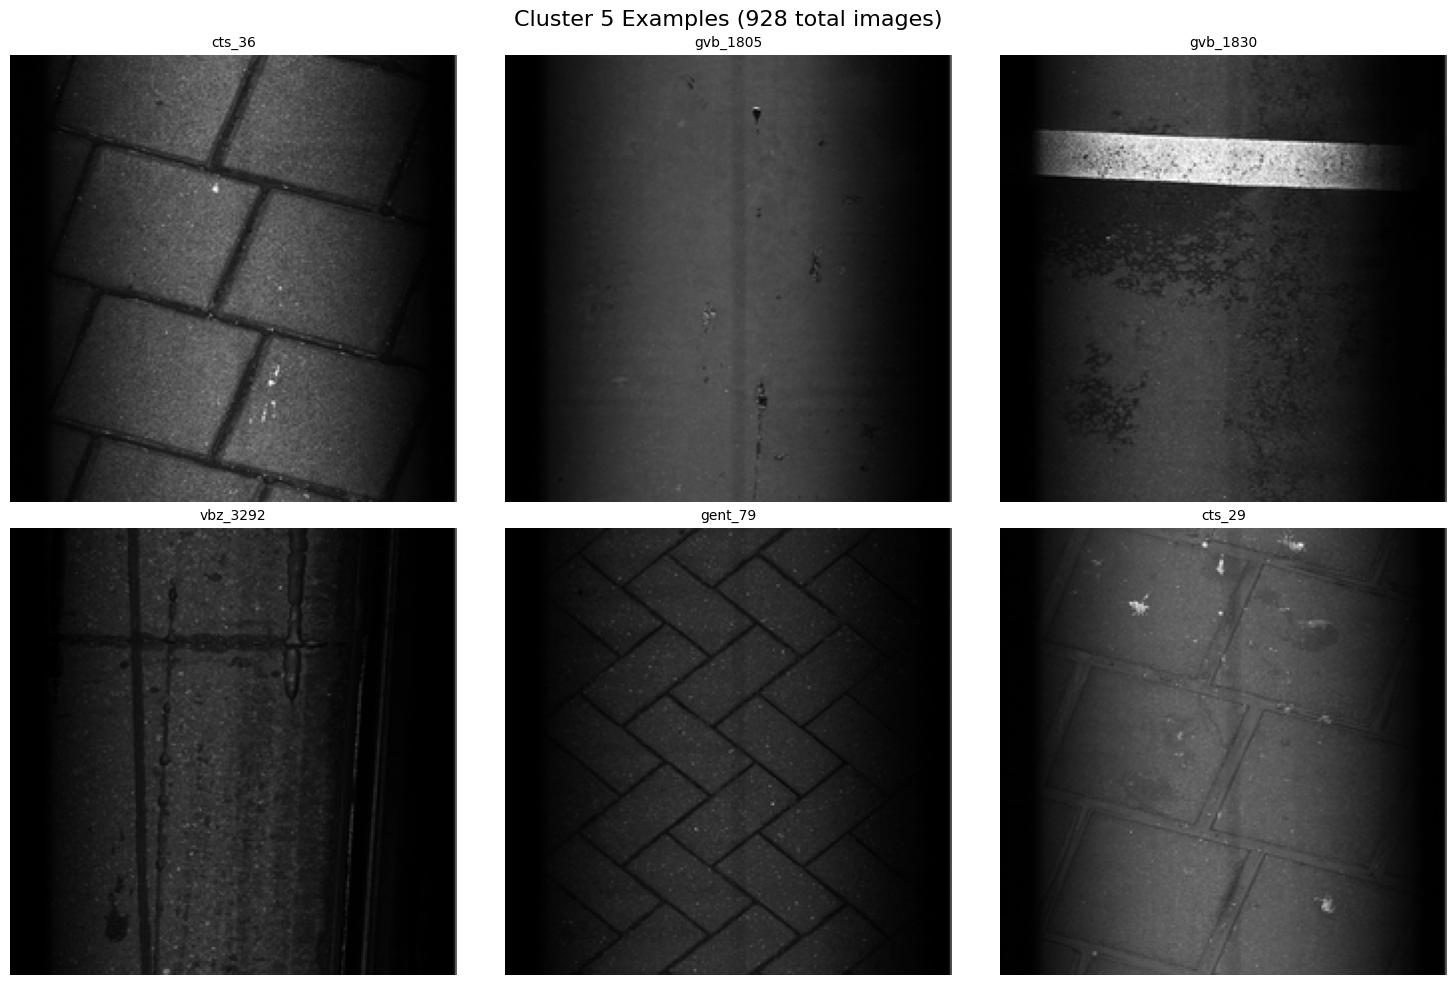

In [18]:
def display_cluster_examples(image_files, cluster_id, n_examples=6):
    """Display example images from a specific cluster."""
    # Collect all images that belong to the requested cluster
    cluster_images = [img for img in image_files if img['cluster'] == cluster_id]
    
    if not cluster_images:
        print(f"No images found for cluster {cluster_id}")
        return
    
    # Randomly sample examples (set np.random.seed(...) earlier for reproducibility)
    examples = np.random.choice(cluster_images, min(n_examples, len(cluster_images)), replace=False)
    
    # Create subplot grid (3 columns; rows computed from sample size)
    cols = 3
    rows = (len(examples) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Cluster {cluster_id} Examples ({len(cluster_images)} total images)', fontsize=16)
    
    for i, img_info in enumerate(examples):
        row = i // cols
        col = i % cols
        
        # Load and display image; on failure, render a textual placeholder
        try:
            img = Image.open(img_info['filepath'])
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"{img_info['tenant']}_{img_info['sid']}", fontsize=10)
            axes[row, col].axis('off')
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f"Error loading\n{img_info['filename']}", 
                               ha='center', va='center', transform=axes[row, col].transAxes)
            axes[row, col].axis('off')
    
    # Hide any empty subplot cells (if sample size not divisible by #cols)
    for i in range(len(examples), rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    # Save a PNG panel per cluster to RESULTS_PATH
    plt.savefig(f"{RESULTS_PATH}/cluster_{cluster_id}_examples.png", dpi=300, bbox_inches='tight')
    plt.show()

# Render example grids for all discovered clusters ---
print("=" * 80)
print("CLUSTER EXAMPLES")
print("=" * 80)

for cluster_id in sorted(set(cluster_labels)):
    display_cluster_examples(image_files, cluster_id)


## 8. DBSCAN

### 8.1 DBSCAN: Parameter-Grid, Heatmaps & Best-Selection

**Was:**  
- Dichte-basiertes Clustering auf **PCA-Features** mit einem Grid aus `eps × min_samples`.  
- Pro Kombination: Fit/Predict, Metriken (Cluster ohne Noise, Noise-Quote, Silhouette ohne Noise) und anschließende **3 Heatmaps**.  
- Auswahl des „besten“ Settings per **Silhouette** und **Balanced Score** `silhouette * (1 - noise_ratio)` (robuster).

**Warum:**  
- DBSCAN ist empfindlich gegenüber `eps`/`min_samples`. ein Grid liefert eine datengetriebene Auswahl. 
- Balanced Score verhindert triviale Lösungen mit hoher Silhouette aber extremer Noise-Quote.

**Besonderheiten:**  
- Silhouette wird nur berechnet, wenn >1 Cluster vorhanden; **Noise (-1)** wird bei Silhouette **ausgeschlossen**.  
- Für Heatmaps werden negative Silhouetten als **0** visualisiert (bessere Lesbarkeit).  
- Bei sehr hoher Noise-Quote: Parameterbereich erweitern oder **PCA-Komponenten** anpassen; optional **k-Distance-Plot** bzw. **HDBSCAN** prüfen.

**Outputs:**  
- `dbscan_parameter_optimization.png` (Heatmaps), Konsolen-Log der besten Parameter, Objekt `best_dbscan`.


DBSCAN CLUSTERING
Applying DBSCAN on PCA-reduced features...

Testing parameter combinations:
eps values: [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5]
min_samples values: [3, 5, 7, 10, 15, 20]
Total combinations to test: 66

Testing DBSCAN with eps=0.2, min_samples=3...
  Clusters: 60
  Noise points: 1827 (18.3%)
  Silhouette: 0.0045

Testing DBSCAN with eps=0.2, min_samples=5...
  Clusters: 32
  Noise points: 2083 (20.8%)
  Silhouette: 0.1553

Testing DBSCAN with eps=0.2, min_samples=7...
  Clusters: 28
  Noise points: 2333 (23.3%)
  Silhouette: 0.1114

Testing DBSCAN with eps=0.2, min_samples=10...
  Clusters: 14
  Noise points: 2697 (27.0%)
  Silhouette: 0.2687

Testing DBSCAN with eps=0.2, min_samples=15...
  Clusters: 12
  Noise points: 3096 (31.0%)
  Silhouette: 0.4528

Testing DBSCAN with eps=0.2, min_samples=20...
  Clusters: 11
  Noise points: 3363 (33.6%)
  Silhouette: 0.4503

Testing DBSCAN with eps=0.3, min_samples=3...
  Clusters: 23
  Noise points: 408 (4.1%)
 

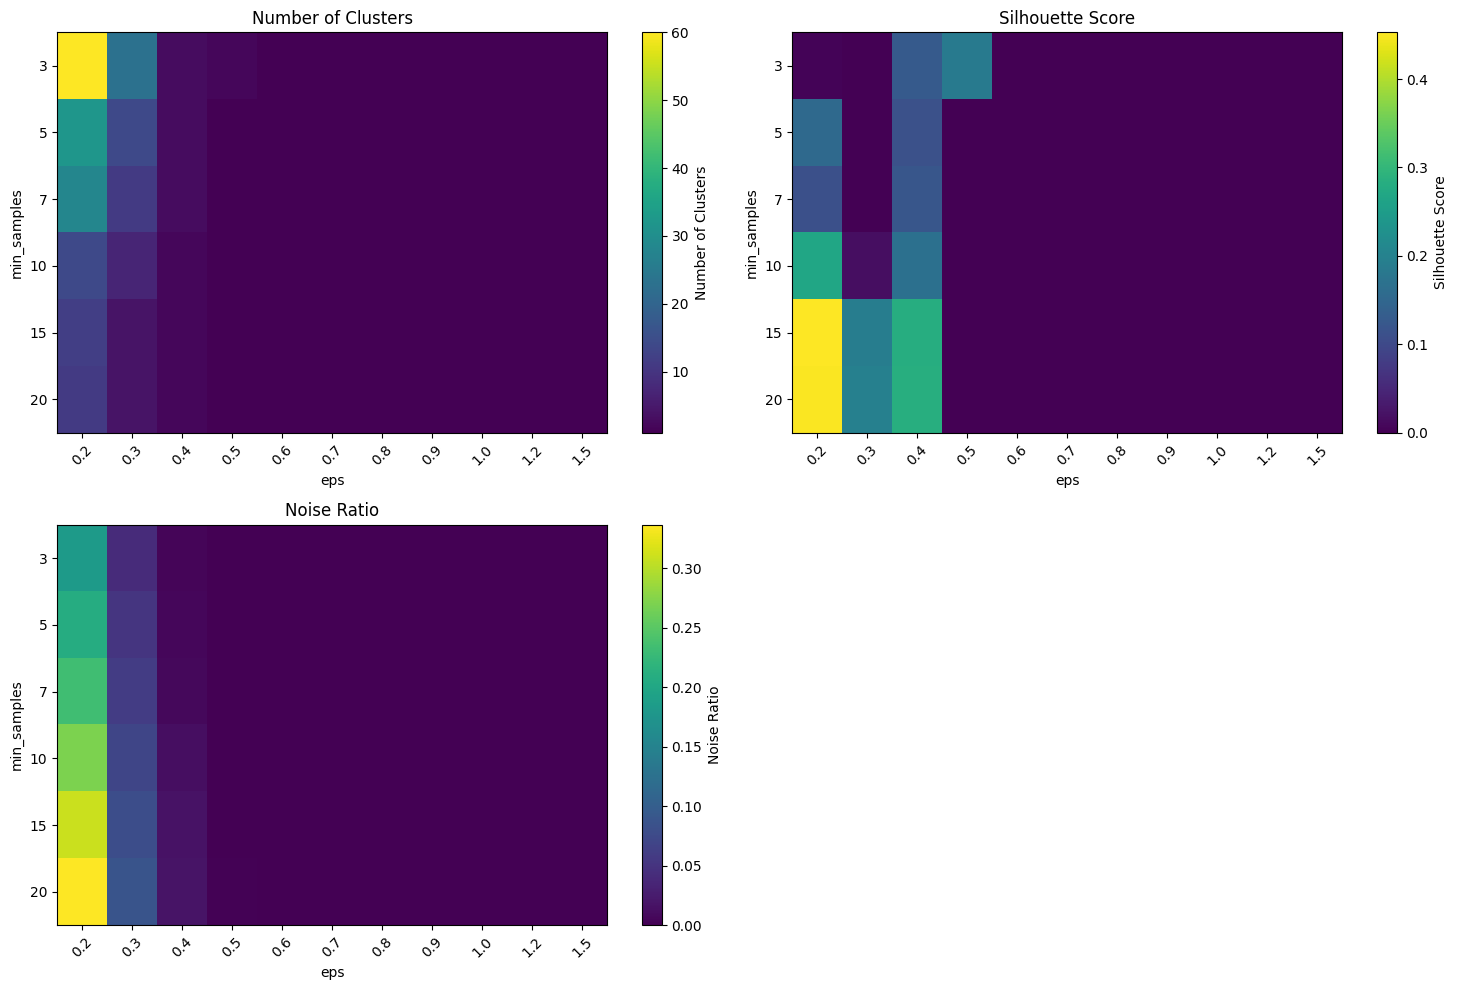

In [19]:
# DBSCAN Clustering
print("=" * 80)
print("DBSCAN CLUSTERING")
print("=" * 80)

# Use PCA features for DBSCAN (better performance in lower dimensions)
print("Applying DBSCAN on PCA-reduced features...")

# Create a grid of parameters to test
eps_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5]
min_samples_values = [3, 5, 7, 10, 15, 20]

print("\nTesting parameter combinations:")
print(f"eps values: {eps_values}")
print(f"min_samples values: {min_samples_values}")
print(f"Total combinations to test: {len(eps_values) * len(min_samples_values)}")

dbscan_results = []

# Test all combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\nTesting DBSCAN with eps={eps}, min_samples={min_samples}...")
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)  # density params: neighborhood radius & min points
        dbscan_labels = dbscan.fit_predict(features_pca)   # run on PCA-reduced features
        
        # Count clusters and noise points
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # exclude noise from cluster count
        n_noise = list(dbscan_labels).count(-1)
        
        # Calculate silhouette score (only if we have more than 1 cluster)
        if n_clusters > 1:
            # Filter out noise points for silhouette calculation
            mask = dbscan_labels != -1
            if mask.sum() > 1:  # Need at least 2 points
                silhouette_avg = silhouette_score(features_pca[mask], dbscan_labels[mask])
            else:
                silhouette_avg = -1
        else:
            silhouette_avg = -1
        
        result = {
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(dbscan_labels),
            'silhouette_score': silhouette_avg,
            'labels': dbscan_labels
        }
        dbscan_results.append(result)
        
        print(f"  Clusters: {n_clusters}")
        print(f"  Noise points: {n_noise} ({result['noise_ratio']*100:.1f}%)")
        print(f"  Silhouette: {silhouette_avg:.4f}")

# Create results visualization
plt.figure(figsize=(15, 10))

# Create a matrix of results
eps_grid, min_samples_grid = np.meshgrid(eps_values, min_samples_values)
n_clusters_grid = np.zeros_like(eps_grid, dtype=float)
silhouette_grid = np.zeros_like(eps_grid, dtype=float)
noise_ratio_grid = np.zeros_like(eps_grid, dtype=float)

# Fill heatmap matrices with metrics per (eps, min_samples)
for result in dbscan_results:
    i = min_samples_values.index(result['min_samples'])
    j = eps_values.index(result['eps'])
    n_clusters_grid[i, j] = result['n_clusters']
    silhouette_grid[i, j] = max(result['silhouette_score'], 0)  # Replace negative scores with 0 (visual clarity)
    noise_ratio_grid[i, j] = result['noise_ratio']

# Plot number of clusters
plt.subplot(221)
plt.imshow(n_clusters_grid, aspect='auto', interpolation='nearest')
plt.colorbar(label='Number of Clusters')
plt.ylabel('min_samples')
plt.xlabel('eps')
plt.title('Number of Clusters')
plt.xticks(range(len(eps_values)), [f'{x:.1f}' for x in eps_values], rotation=45)
plt.yticks(range(len(min_samples_values)), min_samples_values)

# Plot silhouette scores
plt.subplot(222)
plt.imshow(silhouette_grid, aspect='auto', interpolation='nearest')
plt.colorbar(label='Silhouette Score')
plt.ylabel('min_samples')
plt.xlabel('eps')
plt.title('Silhouette Score')
plt.xticks(range(len(eps_values)), [f'{x:.1f}' for x in eps_values], rotation=45)
plt.yticks(range(len(min_samples_values)), min_samples_values)

# Plot noise ratio
plt.subplot(223)
plt.imshow(noise_ratio_grid, aspect='auto', interpolation='nearest')
plt.colorbar(label='Noise Ratio')
plt.ylabel('min_samples')
plt.xlabel('eps')
plt.title('Noise Ratio')
plt.xticks(range(len(eps_values)), [f'{x:.1f}' for x in eps_values], rotation=45)
plt.yticks(range(len(min_samples_values)), min_samples_values)

# Find best results
valid_results = [r for r in dbscan_results if r['silhouette_score'] > 0]
if valid_results:
    # Sort by different metrics
    best_silhouette = max(valid_results, key=lambda x: x['silhouette_score'])  # highest quality by silhouette
    balanced_score = max(valid_results, key=lambda x: x['silhouette_score'] * (1 - x['noise_ratio']))  # quality vs. noise trade-off
    
    print("\nBest results:")
    print("\nBest by silhouette score:")
    print(f"eps={best_silhouette['eps']}, min_samples={best_silhouette['min_samples']}")
    print(f"Clusters: {best_silhouette['n_clusters']}")
    print(f"Noise points: {best_silhouette['n_noise']} ({best_silhouette['noise_ratio']*100:.1f}%)")
    print(f"Silhouette: {best_silhouette['silhouette_score']:.4f}")
    
    print("\nBest balanced (silhouette * (1 - noise_ratio)):")
    print(f"eps={balanced_score['eps']}, min_samples={balanced_score['min_samples']}")
    print(f"Clusters: {balanced_score['n_clusters']}")
    print(f"Noise points: {balanced_score['n_noise']} ({balanced_score['noise_ratio']*100:.1f}%)")
    print(f"Silhouette: {balanced_score['silhouette_score']:.4f}")
    
    # Use balanced score as best result (more robust in practice)
    best_dbscan = balanced_score
else:
    print("\nNo valid DBSCAN results found. Consider adjusting parameters.")
    best_dbscan = dbscan_results[0]  # Use first result as fallback

plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/dbscan_parameter_optimization.png", dpi=300, bbox_inches='tight')
plt.show()


# 9. Reporting und Visualisierung

### 9.1 Visualisierung: K-Means & DBSCAN (Side-by-Side) mit t-SNE
 
**Was:**  
- berechnet ein 2D-t-SNE auf den PCA-Features (`features_pca`) mit stabilen Parametern (`init='pca'`, `learning_rate='auto'`, `dynamische Perplexity`)
- Erstellt Side-by-Side-Visualisierung der K-Means- und DBSCAN-Zuordnungen in separaten Panels
- Verwendet diskrete Farbkarten mit `BoundaryNorm` für saubere Cluster-Trennung und eindeutige Legendenbeschriftung
 
**Warum:**  
- t-SNE wird genutzt, um die 50D-PCA-Features auf 2D zu reduzieren für eine intuitive Visualisierung der Cluster-Struktur
- Side-by-Side Vergleich ermöglicht direkten Vergleich der beiden Methoden
- stabile Parameter ermöglichen reproduzierbare Layouts für Vergleichbarkeit
 
**Besonderheiten:**  
- Noise-Behandlung bei DBSCAN: Noise-Punkte (`-1`) werden explizit in grau dargestellt, reguläre Cluster erhalten `tab10`-Farben
 
**Outputs:**  
- Side-by-Side Plot mit t-SNE-Projektion beider Cluster
- Erstellung der Datei `clustering_tsne_visualization_fixed.png`, die den Plot enthält


CLUSTER VISUALIZATION WITH t-SNE (IMPROVED)
Computing t-SNE embedding with stable parameters...
t-SNE completed with perplexity=50


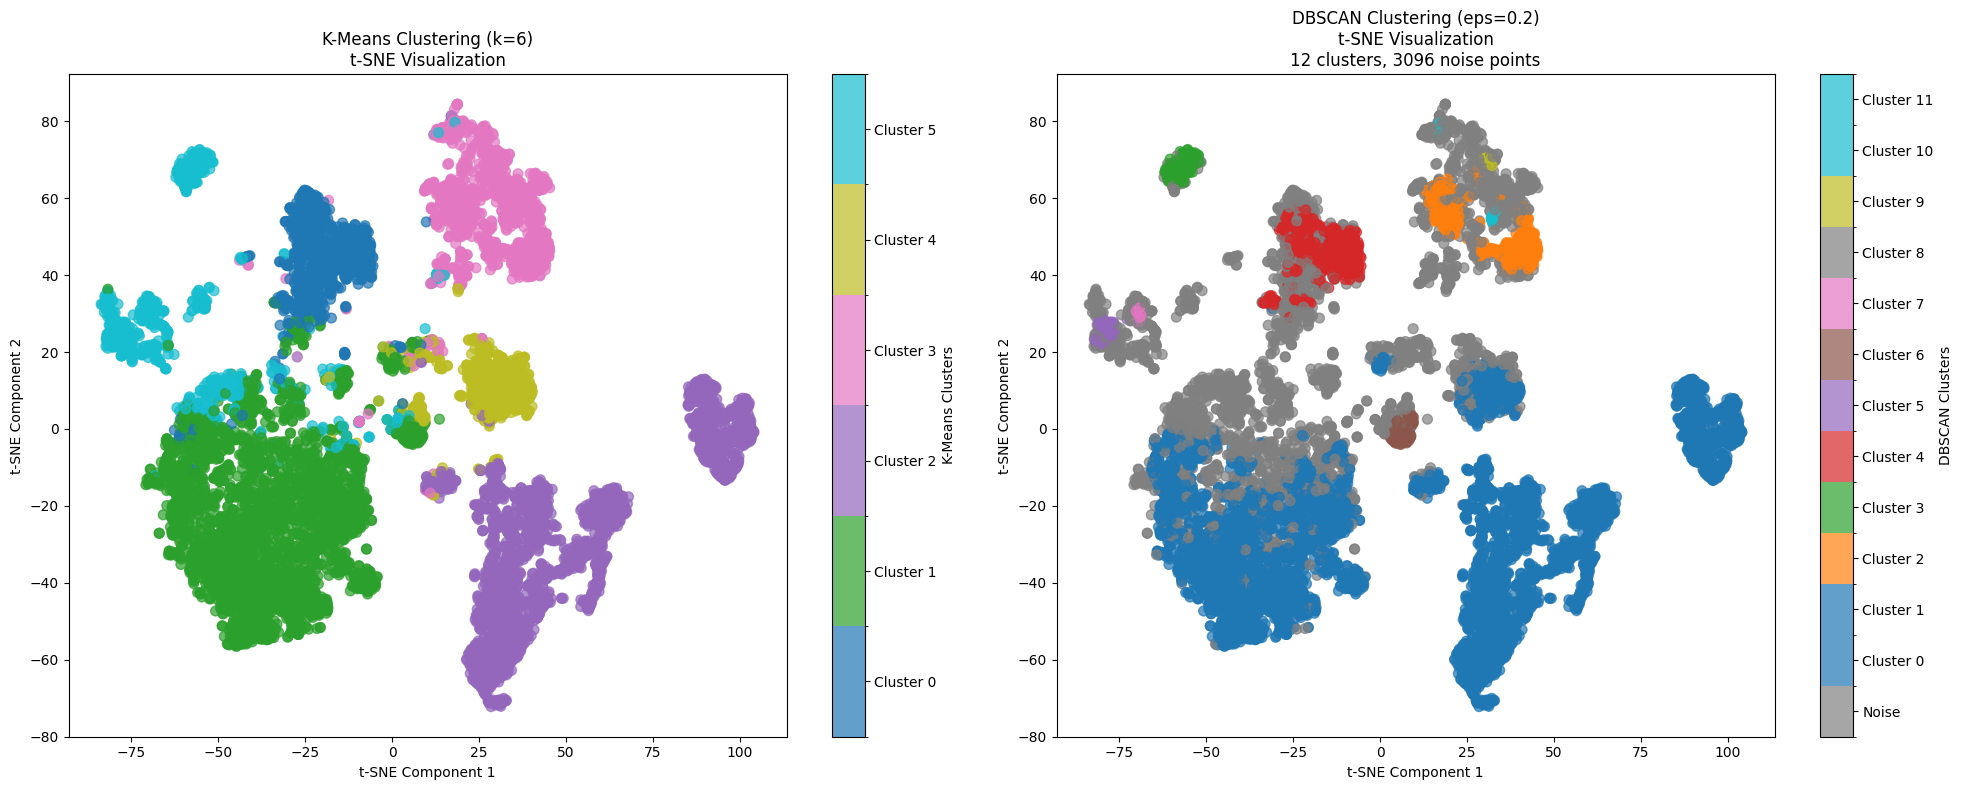

In [20]:
# Visualize clustering results with t-SNE (Fixed Colors & Legends)
print("=" * 80)
print("CLUSTER VISUALIZATION WITH t-SNE (IMPROVED)")
print("=" * 80)

print("Computing t-SNE embedding with stable parameters...")
N = len(features_pca)
# Use stable t-SNE parameters for reproducible and better results
tsne = TSNE(
    n_components=2,
    init='pca',  # PCA initialization for better stability
    learning_rate='auto',  # Adaptive learning rate
    perplexity=min(50, max(5, int(N * 0.01))),  # Dynamic perplexity based on sample size
    max_iter=1500,  # More iterations for convergence
    random_state=RANDOM_STATE,
    metric='euclidean',
    early_exaggeration=12.0
)

tsne_features = tsne.fit_transform(features_pca)
print(f"t-SNE completed with perplexity={tsne.perplexity}")

# Create visualization with fixed discrete colors
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# === K-MEANS PLOT WITH DISCRETE COLORS ===
# Remap K-Means labels to 0..C-1 for consistent coloring
unique_kmeans = sorted(set(cluster_labels))
kmeans_label_map = {old: new for new, old in enumerate(unique_kmeans)}
kmeans_colors = np.array([kmeans_label_map[label] for label in cluster_labels])

# Create discrete colormap for K-Means
n_kmeans_clusters = len(unique_kmeans)
kmeans_cmap = matplotlib.colors.ListedColormap(plt.cm.tab10(np.linspace(0, 1, n_kmeans_clusters)))
kmeans_norm = matplotlib.colors.BoundaryNorm(
    boundaries=np.arange(-0.5, n_kmeans_clusters, 1), 
    ncolors=n_kmeans_clusters
)

scatter1 = axes[0].scatter(
    tsne_features[:, 0],
    tsne_features[:, 1],
    c=kmeans_colors,
    cmap=kmeans_cmap,
    norm=kmeans_norm,
    alpha=0.7,
    s=50
)
axes[0].set_title(f'K-Means Clustering (k={optimal_k})\nt-SNE Visualization')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')

# Discrete colorbar for K-Means
cbar1 = plt.colorbar(scatter1, ax=axes[0], ticks=range(n_kmeans_clusters))
cbar1.set_ticklabels([f'Cluster {unique_kmeans[i]}' for i in range(n_kmeans_clusters)])
cbar1.set_label('K-Means Clusters')

# === DBSCAN PLOT WITH NOISE IN GREY ===
dbscan_colors = best_dbscan['labels'].copy()
unique_dbscan = sorted(set(dbscan_colors))
n_dbscan_clusters = len(unique_dbscan) - (1 if -1 in unique_dbscan else 0)

# Create color mapping: noise (-1) -> 0 (grey), clusters -> 1,2,3...
if -1 in unique_dbscan:
    # Noise gets grey, clusters get tab10 colors
    colors = ['#808080']  # Grey for noise
    colors.extend(plt.cm.tab10(np.linspace(0, 1, n_dbscan_clusters)))
    # Map -1 to 0, others to 1,2,3...
    dbscan_label_map = {-1: 0}
    cluster_idx = 1
    for label in unique_dbscan:
        if label != -1:
            dbscan_label_map[label] = cluster_idx
            cluster_idx += 1
    total_colors = len(unique_dbscan)
else:
    # No noise, just use tab10 for all clusters
    colors = plt.cm.tab10(np.linspace(0, 1, n_dbscan_clusters))
    dbscan_label_map = {label: idx for idx, label in enumerate(unique_dbscan)}
    total_colors = n_dbscan_clusters

dbscan_colors_mapped = np.array([dbscan_label_map[label] for label in dbscan_colors])

# Create discrete colormap for DBSCAN
dbscan_cmap = matplotlib.colors.ListedColormap(colors)
dbscan_norm = matplotlib.colors.BoundaryNorm(
    boundaries=np.arange(-0.5, total_colors, 1), 
    ncolors=total_colors
)

scatter2 = axes[1].scatter(
    tsne_features[:, 0],
    tsne_features[:, 1],
    c=dbscan_colors_mapped,
    cmap=dbscan_cmap,
    norm=dbscan_norm,
    alpha=0.7,
    s=50
)
axes[1].set_title(f'DBSCAN Clustering (eps={best_dbscan["eps"]})\nt-SNE Visualization\n{n_dbscan_clusters} clusters, {best_dbscan["n_noise"]} noise points')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

# Discrete colorbar for DBSCAN
cbar2 = plt.colorbar(scatter2, ax=axes[1], ticks=range(total_colors))
if -1 in unique_dbscan:
    tick_labels = ['Noise'] + [f'Cluster {i}' for i in range(n_dbscan_clusters)]
else:
    tick_labels = [f'Cluster {unique_dbscan[i]}' for i in range(n_dbscan_clusters)]
cbar2.set_ticklabels(tick_labels)
cbar2.set_label('DBSCAN Clusters')

plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/clustering_tsne_visualization_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

### 9.2 K-Nearest Neighbor Grafik bei DBSCAN
 
**Was:**  
- Berechnet für jeden Datenpunkt die Distanz zum k-ten nächsten Nachbarn (k = `best_dbscan['min_samples']`) auf den PCA-Features
- Sortiert diese k-Distanzen absteigend und visualisiert sie als Kurve (K-Distance Plot)
- Überlagert horizontale Referenzlinien für das gewählte best_eps (rot) und andere getestete Epsilon-Werte (grau)
 
**Warum:**  
- Visuelle Epsilon-Validierung: Der Plot zeigt, ob das automatisch gewählte eps am "Elbow" (Knick) der Kurve liegt
- Datengetriebene Parameter-Wahl: Ergänzt die Grid-Search um eine theoretisch fundierte Visualisierung der Dichteverteilung
- Core-Point-Analyse: Punkte oberhalb der eps-Linie werden zu Core-Points → Einschätzung der Cluster-Dichte
 
**Besonderheiten:**  
- Gelber Bereich (5%-20% der sortierten Punkte) zeigt die typische Knick-Zone
- Zählt Punkte oberhalb des gewählten eps als potentielle Core-Points zur quantitativen Analyse
- Zeigt mehrere eps-Kandidaten zur Orientierung (0.3, 0.5, 0.7, 1.0)
 
**Outputs:**
- Plot: `dbscan_k_distance.png` mit sortierter k-Distanz-Kurve und eps-Referenzlinien
- Konsolen-Analyse: Interpretation des gewählten eps und Anzahl potentieller Core-Points

K-DISTANCE PLOT FOR DBSCAN EPS SELECTION
Computing 15-distance plot for eps guidance...


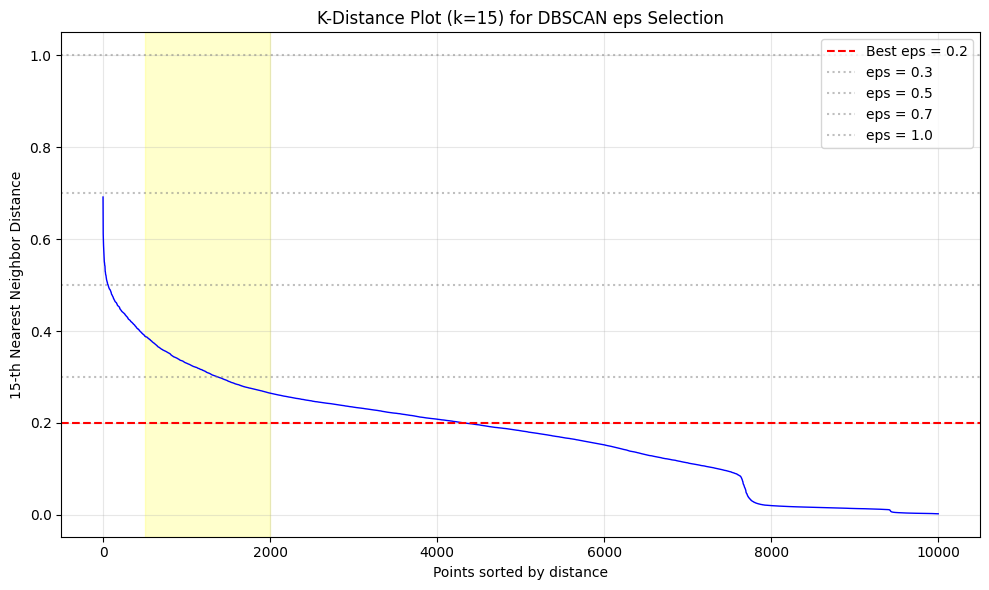


K-Distance Plot Analysis:
- Red line shows selected eps = 0.2
- Look for 'elbow' in the curve to find optimal eps
- Steep increase indicates good density separation
- Current eps captures 4325 points as potential core points


In [21]:
# K-Distance Plot for DBSCAN Parameter Guidance
print("=" * 80)
print("K-DISTANCE PLOT FOR DBSCAN EPS SELECTION")
print("=" * 80)

from sklearn.neighbors import NearestNeighbors

# Use the min_samples from best DBSCAN result
k = best_dbscan['min_samples']
print(f"Computing {k}-distance plot for eps guidance...")

# Fit NearestNeighbors on PCA features
neighbors = NearestNeighbors(n_neighbors=k, metric='euclidean')
neighbors.fit(features_pca)

# Get distances to k-th nearest neighbor for each point
distances, indices = neighbors.kneighbors(features_pca)
k_distances = distances[:, k-1]  # k-th distance (0-indexed)

# Sort distances in descending order
k_distances_sorted = np.sort(k_distances)[::-1]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(k_distances_sorted)), k_distances_sorted, 'b-', linewidth=1)
plt.axhline(y=best_dbscan['eps'], color='red', linestyle='--', 
           label=f'Best eps = {best_dbscan["eps"]}')

# Add some reference lines for other tested eps values
for eps in [0.3, 0.5, 0.7, 1.0]:
    if eps != best_dbscan['eps']:
        plt.axhline(y=eps, color='grey', linestyle=':', alpha=0.5, 
                   label=f'eps = {eps}')

plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title(f'K-Distance Plot (k={k}) for DBSCAN eps Selection')
plt.legend()
plt.grid(True, alpha=0.3)

# Highlight the "elbow" region
elbow_start = int(len(k_distances_sorted) * 0.05)
elbow_end = int(len(k_distances_sorted) * 0.20)
plt.axvspan(elbow_start, elbow_end, alpha=0.2, color='yellow', 
           label='Typical elbow region')

plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/dbscan_k_distance.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nK-Distance Plot Analysis:")
print(f"- Red line shows selected eps = {best_dbscan['eps']}")
print(f"- Look for 'elbow' in the curve to find optimal eps")
print(f"- Steep increase indicates good density separation")
print(f"- Current eps captures {np.sum(k_distances_sorted >= best_dbscan['eps'])} points as potential core points")

### 10. Cluster-Ergebnisse speichern

#### 10.1 Speicher-Helfer definieren (Ordner/Bildkopie/Metadaten)
 
**Was:**  
- es werden drei Hilfsfunktionen für die Speicherung der Cluster-Ergebnisse definiert
- `create_cluster_directories()`: Legt strukturierte Ordnerhierarchie an (`method_name/cluster_<id>/` bzw. `noise/` für DBSCAN)
- `copy_images_to_clusters()`: Kopiert Originalbilder in ihre jeweiligen Cluster-Ordner mit Duplikatsvermeidung
- `save_cluster_metadata()`: Erstellt detaillierte JSON-Metadaten pro Cluster mit Tenant-Statistiken und Bildlisten
 
**Warum:**  
- Clustering-Ergebnisse werden dauerhaft und strukturiert gespeichert für spätere Analyse
- Bilder werden nach Clustern sortiert → vereinfacht manuelle Inspektion und Qualitätskontrolle der Clustering Verfahren
- JSON-File dokumentiert Cluster-Zusammensetzung, Tenant-Verteilung und verwendete Methodik
- Separierte Cluster ermöglichen gezielte Weiterverarbeitung einzelner Gruppen, hierdurch ist ein Labeln der Cluster einfach möglich, um eine spätere Klassifizierung von neuen Daten vornehmen zu können
 
**Besonderheiten:**  
- Ordner-Erstellung und Dateikopien überschreiben nicht bei identischen Dateien (Größenvergleich)
- Noise-Punkte (`-1`) werden speziell im noise/-Ordner gesammelt, reguläre Cluster in `cluster_<id>/`
- Unterstützt sowohl K-Means (`cluster_labels`) als auch DBSCAN (`dbscan_labels`) Parameter
 
**Outputs:**  
- Ordner mit kopierten Originalbildern im festgelegten Dateipfad: `{base_path}/{method_name}/cluster_<id>/`
- Metadaten Dateien je Cluster mit Angabe der `cluster_id`, `total_images`, `tenant_distribution` und den Details der Bilder
- Erstellung von Statistiken zur Anzahl der erfolgreichen Kopien, Anzahl der Fehler (wenn vorhanden) und die Größe der Cluster

In [22]:
def create_cluster_directories(base_path, method_name, cluster_labels, dbscan_labels=None):
    """Create directory structure for clustered images."""
    method_path = Path(base_path) / method_name
    method_path.mkdir(parents=True, exist_ok=True)
    
    if method_name == 'kmeans':
        unique_clusters = sorted(set(cluster_labels))
    else:  # dbscan
        unique_clusters = sorted(set(dbscan_labels))
        # Handle noise points (-1) separately
        if -1 in unique_clusters:
            unique_clusters = [c for c in unique_clusters if c != -1] + [-1]
    
    cluster_dirs = {}
    for cluster_id in unique_clusters:
        if cluster_id == -1:
            cluster_dir = method_path / 'noise'
        else:
            cluster_dir = method_path / f'cluster_{cluster_id}'
        cluster_dir.mkdir(exist_ok=True)
        cluster_dirs[cluster_id] = cluster_dir
    
    return cluster_dirs

def copy_images_to_clusters(image_files, cluster_dirs, cluster_labels, method_name='kmeans', dbscan_labels=None):
    """Copy images to their respective cluster directories."""
    print(f"\nCopying images to {method_name.upper()} cluster directories...")
    
    if method_name == 'kmeans':
        labels_to_use = cluster_labels
    else:  # dbscan
        labels_to_use = dbscan_labels
    
    copied_count = 0
    error_count = 0
    
    for i, img_file in enumerate(image_files):
        try:
            cluster_id = labels_to_use[i]
            source_path = Path(img_file['filepath'])
            target_dir = cluster_dirs[cluster_id]
            target_path = target_dir / source_path.name
            
            # Copy file if it doesn't exist or is different
            if not target_path.exists() or target_path.stat().st_size != source_path.stat().st_size:
                shutil.copy2(source_path, target_path)
                copied_count += 1
            
        except Exception as e:
            print(f"Error copying {img_file['filename']}: {e}")
            error_count += 1
    
    print(f"Successfully copied {copied_count} images")
    if error_count > 0:
        print(f"Errors: {error_count}")
    
    return copied_count, error_count

def save_cluster_metadata(cluster_dirs, image_files, cluster_labels, method_name='kmeans', dbscan_labels=None):
    """Save metadata for each cluster."""
    print(f"\nSaving {method_name.upper()} cluster metadata...")
    
    if method_name == 'kmeans':
        labels_to_use = cluster_labels
    else:  # dbscan
        labels_to_use = dbscan_labels
    
    for cluster_id, cluster_dir in cluster_dirs.items():
        # Get images for this cluster
        cluster_images = []
        for i, img_file in enumerate(image_files):
            if int(labels_to_use[i]) == cluster_id:  # Convert numpy int32 to Python int
                cluster_images.append({
                    'filename': img_file['filename'],
                    'tenant': img_file['tenant'],
                    'sid': img_file['sid'],
                    'original_name': img_file['original_name']
                })
        
        # Calculate statistics
        tenant_counts = Counter([img['tenant'] for img in cluster_images])
        
        metadata = {
            'cluster_id': int(cluster_id) if isinstance(cluster_id, (np.integer, np.int32, np.int64)) else cluster_id,  # Ensure cluster_id is JSON serializable
            'method': method_name,
            'total_images': len(cluster_images),
            'tenant_distribution': dict(tenant_counts),
            'images': cluster_images
        }
        
        # Save metadata
        metadata_file = cluster_dir / 'cluster_metadata.json'
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
    
    print(f"Metadata saved for {len(cluster_dirs)} clusters")

#### 10.2 K-Means-Cluster speichern (Ausführung)
 
**Was:**  
- Führt die K-Means-Cluster-Speicherung mit den in Abschnitt 10.1 definierten Hilfsfunktionen aus
- erstellt je gefundenem Cluster einen Ordner in der definierten Ordnerstruktur
- generiert die zuvor definierten Statistiken als JSON-Datei
 
**Warum:**  
- vereinfachte visuelle Kontrolle
- persistente Archivierung zur späteren Analyse
- gezielte Weiterverarbeitung
- direkte Vergleiche mit vorherigen Läufen durch Anlage der Ordnerstruktur inklusive Timestamp
 
**Besonderheiten:**  
- Zeitstempel-basierte Pfade für eindeutige Versionierung
- Ausgabe von detaillierten Statistiken und Fehler-Tracking
 
**Outputs:**  
- kopierte Originalbilder in der gewählten Ordnerstruktur `{CLUSTERS_PATH}/kmeans/cluster_<0..k-1>/`
- Metadaten Datei `cluster_metadata.json` für jedes Cluster
- Anzeige der Anzahl erstellter Ordner, Cluster-Größen und Kopierstatistiken (Erfolg/Fehler)
- Nennung des Speicherorts als Bestätigung `./results_{TIMESTAMP}/clustered_images/kmeans/`

In [23]:
# Save K-Means clustering results to timestamped directories
print("=" * 80)
print("SAVING K-MEANS CLUSTERS TO TIMESTAMPED DIRECTORIES")
print("=" * 80)

print(f"Using timestamped cluster directory: {CLUSTERS_PATH}")

# Create K-Means cluster directories
kmeans_dirs = create_cluster_directories(CLUSTERS_PATH, 'kmeans', cluster_labels)

print(f"Created K-Means cluster directories:")
for cluster_id, cluster_dir in sorted(kmeans_dirs.items()):
    cluster_size = sum(1 for label in cluster_labels if label == cluster_id)
    print(f"  {cluster_dir.name}: {cluster_size} images")

# Copy images to K-Means clusters
kmeans_copied, kmeans_errors = copy_images_to_clusters(
    image_files, kmeans_dirs, cluster_labels, 'kmeans'
)

# Save K-Means cluster metadata
save_cluster_metadata(kmeans_dirs, image_files, cluster_labels, 'kmeans')

print(f"\nK-Means clustering results saved to: {Path(CLUSTERS_PATH) / 'kmeans'}")

SAVING K-MEANS CLUSTERS TO TIMESTAMPED DIRECTORIES
Using timestamped cluster directory: ./results_20250907_143420/clustered_images
Created K-Means cluster directories:
  cluster_0: 944 images
  cluster_1: 3571 images
  cluster_2: 2562 images
  cluster_3: 1345 images
  cluster_4: 650 images
  cluster_5: 928 images

Copying images to KMEANS cluster directories...
Successfully copied 10000 images

Saving KMEANS cluster metadata...
Metadata saved for 6 clusters

K-Means clustering results saved to: results_20250907_143420/clustered_images/kmeans


#### 10.3 DBSCAN-Cluster speichern (Ausführung)
 
**Was:**  
- Führt die DBSCAN-Cluster-Speicherung mit den in Abschnitt 10.1 definierten Hilfsfunktionen aus
- erstellt je gefundenem Cluster einen Ordner in der definierten Ordnerstruktur, zusätzlich wird ein Ordner für die noise Punkte eingeführt
- generiert die zuvor definierten Statistiken als JSON-Datei
 
**Warum:**  
- Ermöglichung der Analyse anomaler Bilder zur Identifizierung von Ausreißern
- manuelle Überprüfung der dichtebasierten Gruppierung
- direkter Vergleich beider Clustering Ansätze möglich
 
**Besonderheiten:**  
- Nutzt die "balanced score" Parameterwahl (`silhouette * (1 - noise_ratio)`) statt reiner Silhouette-Optimierung
 
**Outputs:**  
- kopierte Originalbilder in der gewählten Ordnerstruktur `{CLUSTERS_PATH}/dbscan/cluster_<0..n>/` + `noise/`
- Metadaten Datei `cluster_metadata.json` für jedes Cluster
- Anzeige der Anzahl erstellter Ordner, Cluster-Größen und Kopierstatistiken (Erfolg/Fehler)
- Nennung des Speicherorts als Bestätigung `./results_{TIMESTAMP}/clustered_images/dbscan/`


In [24]:
# Save DBSCAN clustering results to timestamped directories
print("=" * 80)
print("SAVING DBSCAN CLUSTERS TO TIMESTAMPED DIRECTORIES")
print("=" * 80)

print(f"Using timestamped cluster directory: {CLUSTERS_PATH}")

# Add DBSCAN cluster labels to image files for consistency
dbscan_labels = best_dbscan['labels']
for i, img_file in enumerate(image_files):
    img_file['dbscan_cluster'] = int(dbscan_labels[i])

# Create DBSCAN cluster directories
dbscan_dirs = create_cluster_directories(CLUSTERS_PATH, 'dbscan', None, dbscan_labels)

print(f"Created DBSCAN cluster directories:")
for cluster_id, cluster_dir in sorted(dbscan_dirs.items()):
    cluster_size = sum(1 for label in dbscan_labels if label == cluster_id)
    if cluster_id == -1:
        print(f"  {cluster_dir.name} (noise): {cluster_size} images")
    else:
        print(f"  {cluster_dir.name}: {cluster_size} images")

# Copy images to DBSCAN clusters
dbscan_copied, dbscan_errors = copy_images_to_clusters(
    image_files, dbscan_dirs, None, 'dbscan', dbscan_labels
)

# Save DBSCAN cluster metadata
save_cluster_metadata(dbscan_dirs, image_files, None, 'dbscan', dbscan_labels)

print(f"\nDBSCAN clustering results saved to: {Path(CLUSTERS_PATH) / 'dbscan'}")

SAVING DBSCAN CLUSTERS TO TIMESTAMPED DIRECTORIES
Using timestamped cluster directory: ./results_20250907_143420/clustered_images
Created DBSCAN cluster directories:
  noise (noise): 3096 images
  cluster_0: 2494 images
  cluster_1: 2890 images
  cluster_2: 477 images
  cluster_3: 166 images
  cluster_4: 537 images
  cluster_5: 98 images
  cluster_6: 123 images
  cluster_7: 41 images
  cluster_8: 33 images
  cluster_9: 14 images
  cluster_10: 14 images
  cluster_11: 17 images

Copying images to DBSCAN cluster directories...
Successfully copied 10000 images

Saving DBSCAN cluster metadata...
Metadata saved for 13 clusters

DBSCAN clustering results saved to: results_20250907_143420/clustered_images/dbscan


### 11. Tenant-Cluster-Analyse (Heatmap & Detailstatistik)
**Was:**  
- Baut eine Tenant×Cluster-Matrix auf mit zeilenweiser Normalisierung und berechnet Prozentanteile je Tenant pro Cluster
- Erstellt eine Seaborn-Heatmap (`sns.heatmap`) mit Zellbeschriftung und `YlOrRd`-Farbskala zur Visualisierung der Verteilungen
 
**Warum:**  
- Identifiziert tenant-spezifische Clustering-Muster. Zeigt an, ob bestimmte Verkehrsunternehmen charakteristische Untergrund-/Situationstypen aufweisen
- Starke Ungleichverteilungen können auf systematische Bias oder domänenspezifische Besonderheiten hinweisen
- Visualisiert, ob das Clustering echte visueller Muster oder nur tenant-basierte Artefakte erfasst hat
 
**Outputs:**  
- Heatmap-Grafik: `tenant_cluster_heatmap.png` in `RESULTS_PATH` mit prozentualer Tenant-Verteilung über alle Cluster
- Konsolen-Report: Detaillierte Aufschlüsselung je Tenant mit Gesamtzahl und clusterspezifischen Prozent-/Absolutwerten

TENANT DISTRIBUTION ANALYSIS


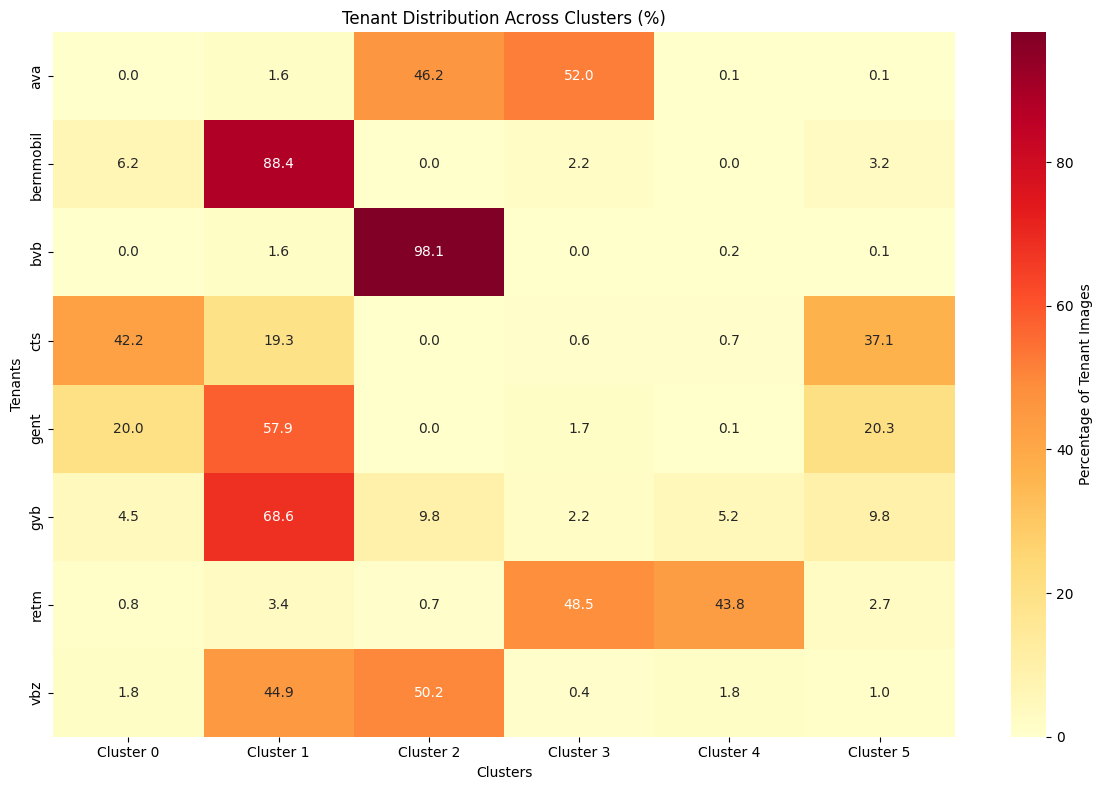


Detailed Tenant-Cluster Distribution:

ava (1250 images):
  Cluster 1: 20 images (1.6%)
  Cluster 2: 578 images (46.2%)
  Cluster 3: 650 images (52.0%)
  Cluster 4: 1 images (0.1%)
  Cluster 5: 1 images (0.1%)

bernmobil (1250 images):
  Cluster 0: 78 images (6.2%)
  Cluster 1: 1105 images (88.4%)
  Cluster 3: 27 images (2.2%)
  Cluster 5: 40 images (3.2%)

bvb (1250 images):
  Cluster 1: 20 images (1.6%)
  Cluster 2: 1226 images (98.1%)
  Cluster 4: 3 images (0.2%)
  Cluster 5: 1 images (0.1%)

cts (1250 images):
  Cluster 0: 528 images (42.2%)
  Cluster 1: 241 images (19.3%)
  Cluster 3: 8 images (0.6%)
  Cluster 4: 9 images (0.7%)
  Cluster 5: 464 images (37.1%)

gent (1250 images):
  Cluster 0: 250 images (20.0%)
  Cluster 1: 724 images (57.9%)
  Cluster 3: 21 images (1.7%)
  Cluster 4: 1 images (0.1%)
  Cluster 5: 254 images (20.3%)

gvb (1250 images):
  Cluster 0: 56 images (4.5%)
  Cluster 1: 857 images (68.6%)
  Cluster 2: 122 images (9.8%)
  Cluster 3: 28 images (2.2%)
  Clus

In [25]:
# Analyze tenant distribution across clusters
print("=" * 80)
print("TENANT DISTRIBUTION ANALYSIS")
print("=" * 80)

# Create tenant-cluster matrix
tenant_cluster_matrix = defaultdict(lambda: defaultdict(int))
total_by_tenant = defaultdict(int)

for img_file in image_files:
    tenant = img_file['tenant']
    cluster = img_file['cluster']
    tenant_cluster_matrix[tenant][cluster] += 1
    total_by_tenant[tenant] += 1

# Convert to DataFrame for easier visualization
tenants = sorted(total_by_tenant.keys())
clusters = sorted(set(cluster_labels))

matrix_data = []
for tenant in tenants:
    row = []
    for cluster in clusters:
        count = tenant_cluster_matrix[tenant][cluster]
        percentage = (count / total_by_tenant[tenant]) * 100
        row.append(percentage)
    matrix_data.append(row)

# Create heatmap
plt.figure(figsize=(12, 8))
heatmap_data = np.array(matrix_data)
sns.heatmap(
    heatmap_data,
    xticklabels=[f'Cluster {c}' for c in clusters],
    yticklabels=tenants,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Percentage of Tenant Images'}
)
plt.title('Tenant Distribution Across Clusters (%)')
plt.xlabel('Clusters')
plt.ylabel('Tenants')
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/tenant_cluster_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\nDetailed Tenant-Cluster Distribution:")
for tenant in tenants:
    print(f"\n{tenant} ({total_by_tenant[tenant]} images):")
    for cluster in clusters:
        count = tenant_cluster_matrix[tenant][cluster]
        percentage = (count / total_by_tenant[tenant]) * 100
        if count > 0:
            print(f"  Cluster {cluster}: {count} images ({percentage:.1f}%)")

### 12. Clustering-Report (JSON) erstellen & Kernergebnisse ausgeben
**Was:**  
- erstellt `clustering_report.json` mit Zeitstempel-Informationen, Run-Metadaten und vollständigen Clustering-Ergebnissen
- Sammelt Dataset-Info (Bildanzahl, Feature-Dimension, PCA-Varianz), K-Means-Resultate (optimal_k, Silhouette-Scores, Evaluation-Historie) und DBSCAN-Parameter
- Integriert Tenant-Cluster-Analyse mit detaillierter Verteilungsmatrix pro Tenant über alle Cluster
 
**Warum:**  
- Alle Parameter, Metriken und Ergebnisse werden zentral für Nachvollziehbarkeit und Vergleichbarkeit archiviert
- Run-spezifische Metadaten ermöglichen systematische Analyse von Clustering-Stabilität über mehrere Läufe
- Parallele Dokumentation von K-Means und DBSCAN erleichtert objektive Bewertung beider Ansätze
- Geschäftsspezifische Analyse zeigt, ob Clustering domänenrelevante Muster (Verkehrsunternehmen) erfasst
 
**Outputs:**  
- JSON-Report `clustering_report.json` in `RESULTS_PATH` mit vollständiger Run-Dokumentation und Parametern
- Kompakte Übersicht mit Timestamp, optimalen Parametern, Cluster-/Noise-Anzahlen und PCA-Varianz in der Ausgabe
- Absolute Pfade zu Analysis- und Cluster-Verzeichnissen für einfache Navigation


In [26]:
# Generate comprehensive clustering report with timestamp info
print("=" * 80)
print("TIMESTAMPED CLUSTERING ANALYSIS SUMMARY")
print("=" * 80)

# Compile results with timestamp information
clustering_report = {
    'run_info': {
        'timestamp': TIMESTAMP,
        'run_date': time.strftime('%Y-%m-%d %H:%M:%S'),
        'analysis_results_path': str(Path(RESULTS_PATH).resolve()),
        'clustered_images_path': str(Path(CLUSTERS_PATH).resolve())
    },
    'dataset_info': {
        'total_images': int(len(image_files)),
        'feature_dimension': int(FEATURE_DIM),
        'pca_components': int(PCA_COMPONENTS),
        'pca_explained_variance': float(pca.explained_variance_ratio_.sum()),
        'tenant_distribution': {k: int(v) for k, v in tenant_distribution.items()}
    },
    'kmeans_results': {
        'optimal_k': int(optimal_k),
        'silhouette_score': float(silhouette_scores[best_silhouette_idx]),
        'cluster_sizes': {int(k): int(v) for k, v in Counter(cluster_labels).items()},
        'evaluation_results': [
            {
                'k': int(r['k']),
                'inertia': float(r['inertia']),
                'silhouette_score': float(r['silhouette_score'])
            } for r in kmeans_results
        ]
    },
    'dbscan_results': {
        'best_eps': float(best_dbscan['eps']),
        'min_samples': int(best_dbscan['min_samples']),
        'n_clusters': int(best_dbscan['n_clusters']),
        'n_noise': int(best_dbscan['n_noise']),
        'silhouette_score': float(best_dbscan['silhouette_score'])
    },
    'tenant_cluster_analysis': {
        tenant: {
            'total_images': int(total_by_tenant[tenant]),
            'cluster_distribution': {int(k): int(v) for k, v in tenant_cluster_matrix[tenant].items()}
        } for tenant in tenants
    }
}

# Save results to timestamped directory
with open(f"{RESULTS_PATH}/clustering_report.json", 'w') as f:
    json.dump(clustering_report, f, indent=2)

# Print summary
print(f"Analysis completed successfully!")
print(f"\nRun Information:")
print(f"- Timestamp: {TIMESTAMP}")
print(f"- Analysis results saved to: {RESULTS_PATH}")
print(f"- Clustered images saved to: {CLUSTERS_PATH}")

print(f"\nKey Findings:")
print(f"- Optimal number of clusters (K-Means): {optimal_k}")
print(f"- Best silhouette score: {silhouette_scores[best_silhouette_idx]:.4f}")
print(f"- DBSCAN found {best_dbscan['n_clusters']} clusters with {best_dbscan['n_noise']} noise points")
print(f"- PCA captured {pca.explained_variance_ratio_.sum():.1%} of the variance")

print(f"\nCluster sizes (K-Means):")
cluster_sizes = Counter(cluster_labels)
for cluster_id, size in sorted(cluster_sizes.items()):
    percentage = (size / len(cluster_labels)) * 100
    print(f"  Cluster {cluster_id}: {size} images ({percentage:.1f}%)")

TIMESTAMPED CLUSTERING ANALYSIS SUMMARY
Analysis completed successfully!

Run Information:
- Timestamp: 20250907_143420
- Analysis results saved to: ./results_20250907_143420/clustering_analysis
- Clustered images saved to: ./results_20250907_143420/clustered_images

Key Findings:
- Optimal number of clusters (K-Means): 6
- Best silhouette score: 0.4285
- DBSCAN found 12 clusters with 3096 noise points
- PCA captured 91.5% of the variance

Cluster sizes (K-Means):
  Cluster 0: 944 images (9.4%)
  Cluster 1: 3571 images (35.7%)
  Cluster 2: 2562 images (25.6%)
  Cluster 3: 1345 images (13.5%)
  Cluster 4: 650 images (6.5%)
  Cluster 5: 928 images (9.3%)


## 13. Ergebnisse der Clustering Phase
 
- Das dichtebasierte Cluster mit DBSCAN konnte keinen zuverlässigen Erfolg liefern, trotz vielfacher Anpassung der Parameter.
- Die Ergebnisse über die K-Means-Methode waren zufriedenstellend.
- Die Ergebnisse der Cluster wurden mit drei unterschiedlichen Metriken bewertet. Neben den gezeigten Metriken wurden in einer separaten Analyse weitere Cluster-Gütemaße evaluiert, diese Ergebnisse sind in diesem Notebook noch nicht enthalten. Konkret kamen der Silhouette Score, der Davies–Bouldin Index und der Calinski–Harabasz Index zum Einsatz. Für Hintergrund und einen vergleichenden Überblick siehe: Arbelaitz et al. (2013).
- Es wurde versucht mit Hilfe von einer Bildvorverarbeitung die Bilder vorzuverarbeiten, um z.B. dunkle Bilder aufzuhellen. Dies wurde im Schritt 5.1 optional in diesem Notebook eingebaut. Es konnte allerdings kein nennenswerter Effekt bzw. Verschlechterungen festgestellt werden, weshalb wir uns im folgenden dazu entschieden haben keine Bildvorverarbeitung vorzunehmen.
- Zusätzlich wurden folgende Konfigurationen getestet. Diese Ergebnisse sind in diesem Notebook noch nicht enthalten.
    - Feature-Extraction-Model: ResNet50,VGG16
    - je Modell verschiedene Layer im Model:
    `
    'levels': {
            'top': {'pooling': 'avg', 'layer': None},
            'mid': {'layer': 'conv4_block6_out'/'block4_conv3'}
            'low': {'layer': 'conv3_block4_out'/'block2_conv2'}
        }
    ` 
- Als beste Konfiguration hat sich das ResNet50 mit conv4_block6_out als Layer und keiner Bildvorverarbeitung herausgestellt.
    - Die Ergebnisse aller Experimente sind in der mitgeschickten results.json.
- Es wurden zwei Clustering Läufe mit jeweils 10.000 Bildern initialisiert (also insgesamt 20.000 unterschiedlichen Bildern). Ein Test mit 50.000 Bildern führte zu nicht plausiblen Clustern mit K-Means und wurde deshalb verworfen. Eine Analyse, weshalb der Lauf mit 50.000 Bildern nicht funktionierte wurde nicht angestrebt, da ein Clustering mit 20.000 Bildern für unsere Zwecke vollkommen ausreichend ist.
- Die entstandenen 5 Cluster wurden anschließend manuell gesichtet und bereinigt. Es wurden folgende fünf Klassen identifiziert:
    - Beton/Asphalt
    - Gras/natürliche Untergründe (z.B. auch Laub)
    - Schotter
    - Stein (verschiedene Pflaster-Arten)
    - Messfehler (zu dunkle Bilder, verrauschte Bilder)
- Während der Bereinigung wurden fehlerhaft zugeordnete Bilder manuell entfernt, bevor ein Training des Klassifizierungsmodell stattfindet. Die entfernten Bilder wurden gesammelt und können somit später als Spezialfälle gesondert analysiert werden.
- Das Ziel durch das Clustering die Daten zu sortieren und für das Labeling vorzubereiten konnte dadurch erreicht werden.